# ✍🏻 Abstract  
  
**❖ 분석 과제**

- 클로젯셰어 최근 3개월 신규 구매 분석  
- 구매 소요 시간 분석 : 가입일로부터 구매일까지 전환된 소요시간 분석              
- 구매 상품 트렌드 분석 : 유저당 주문 수량 분석  
- 주문 아이템 분석  
  
  
**❖ 분석 방법 및 단계**  
- 분석 과제 수행 : EDA 및 코호트 분석 등 
- 분석을 토대로 액션 플랜 구체화 

# ✍🏻 Intro  
**❖ 클로젯 셰어 소개** 
- 모든 개인과 브랜드를 연결하여 서로의 패션 아이템을 공유하는 패션 셰어링 플랫폼  
- '옷은 사도 사도 없다'라는 쇼퍼들의 고민에서 착안. 커다란 옷장을 만들어 서로의 옷을 공유하자! 
- 평소 쉽게 살 수 없는 명품 브랜드를 타겟팅한 멤버쉽 제도를 운영하여 흔한 옷이 아닌, '특별한 옷을 빌린다'라는 이미지로 서비스 브랜딩 차별화 

**❖ 클로젯 셰어 비지니스 모델 소개**
- 비지니스 모델로 특허 받은 회사
- 자주입지 않는 럭셔리 브랜드의 아이템들을 공유하여 쉐어러에게는 수익창출의 기회를 제공,구매자에게는 럭셔리 브랜드의 아이템을 저렴하게 사용해보는 경험을 선사!
  
**❖ 클로젯 셰어 현황**
- 2019년 8월 시리즈 A 투자 이후 스마트 물류 시스템 설계로 물류 센터를 확장하고, DB자동화를 위한 R&D공간을 마련한 이후 대규모 직원 채용을 통한 빠른 성장 도모   
  
**❖ 클로젯 셰어 문제점** 
- 꾸준한 성장세 대비 직원의 이탈율이 높음  
- 공유 경제 특성상 많고 다양한 서비스의 동시다발적 자동화해야하는 어려움
- 다양한 타겟층을 형성하고 있지 않음  
  
**❖ 결론**  
- 지속적인 투자가 없다면 성장이 어려울 수 있음.  
- 데이터 분석에 기반한 동시다발적 서비스 자동화 필요: 공유경제 사업은 상대적으로 저렴한가격에 바이(buy) 사이드와 셀(sell) 사이드 양쪽 모두에 만족을 주어야 하기 때문에 중간자 역할인 사업자는 거래 하나 하나에 큰 수익을 남길 수 없음. 따라서 비용을 최소화시키면서 동시에 수요를 극대화하는 전략을 취해야 하며 가장 좋은 전략은 효율적인 데이터 분석에 기반한 자동화 시스템을 구축하는 것임. 
  
**이러한 문제 의식을 기반으로 2021년 1~3월 데이터 분석을 아래와 같이 수행함**

# ✍🏻 Data Load  
## Library Import 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns 
import squarify

sns.set_style(style="darkgrid")

# KMeans 모델링
from sklearn.cluster import KMeans
from sklearn import preprocessing

#추천 시스템 library
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE

import re
import platform
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')
    
import missingno as msno
from math import ceil

from datetime import datetime, timezone, timedelta
pd.options.display.max_rows=100

## Dataset Load  

- brandnm : 검색 불가능한 세 가지 제품을 제외하고는 모두 채움. 수가 매우 적으므로 드롭하지 않기로 함. 
- reg_date : USER 컬럼을 통해 채움  
- app_yn : 결측치는 '앱 사용하지 않음'으로 모두 N으로 채움 

In [2]:
data = pd.read_csv('closetshare.csv')

In [3]:
#app_yn 결측치 -> N으로 
data['app_yn'].fillna('N', inplace=True)

In [4]:
print(f'데이터셋 구조 : {data.shape}')
print('='*80)
data.info()

데이터셋 구조 : (1471, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brandnm     1469 non-null   object
 1   goodsnm     1471 non-null   object
 2   USER        1471 non-null   object
 3   reg_date    1471 non-null   object
 4   order_date  1471 non-null   object
 5   p_type      1471 non-null   object
 6   sub_type    1471 non-null   object
 7   app_yn      1471 non-null   object
dtypes: object(8)
memory usage: 92.1+ KB


# ✍🏻 Basic EDA   

## 유저 정보  
- 2021년 신규 고객 정보가 다수임  

In [5]:
print(f'데이터셋에 있는 유저의 수(동일인물 포함) : {data["USER"].count()}')
print(f'데이터셋에 있는 유저의 수(동일인물 배제) : {data["USER"].nunique()}')

데이터셋에 있는 유저의 수(동일인물 포함) : 1471
데이터셋에 있는 유저의 수(동일인물 배제) : 1234


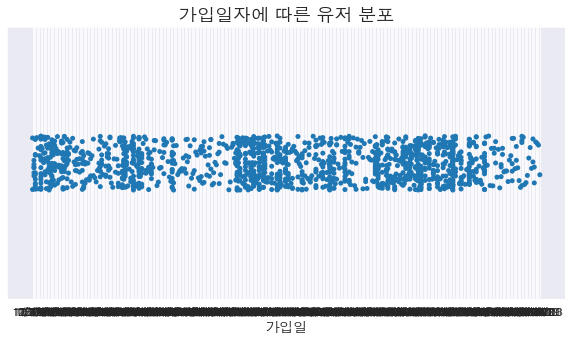

In [6]:
f=plt.figure(figsize=(10,5))
sns.stripplot(x='reg_date',data=data)
plt.title('가입일자에 따른 유저 분포', fontsize=18)
plt.xlabel('가입일', fontsize=14);

## 대여 주문 정보  
- 2021년 1~3월 대여 주문 정보임

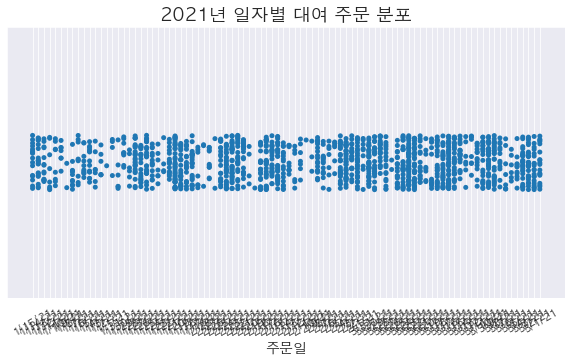

In [7]:
f=plt.figure(figsize=(10,5))
sns.stripplot(x='order_date',data=data)
plt.title('2021년 일자별 대여 주문 분포', fontsize=18)
plt.xticks(rotation=30)
plt.xlabel('주문일', fontsize=14);

## 이용권, 앱 사용 여부, 대여 아이템 정보
- 7일권 이용자 보다 4일권 이용자의 수가 많음  
- 대부분의 유저가 앱을 사용해서 물건을 대여함 
- 가장 많이 대여한 품목은 가방 
- 눈에 띄는 차이점은 드레스는 확실히 4일권의 비중이 높음

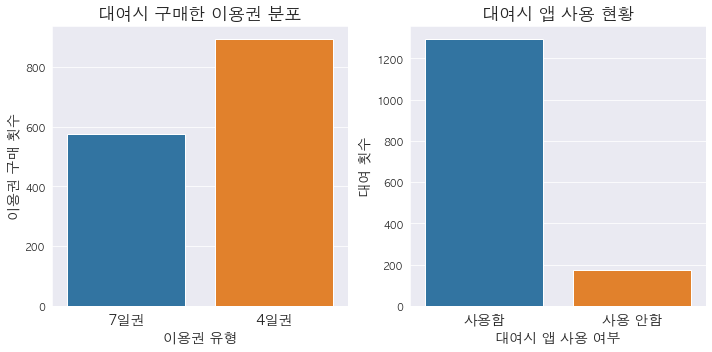

In [8]:
f, axes=plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='p_type', data=data, ax=axes[0])
axes[0].set_title('대여시 구매한 이용권 분포', fontsize=17)
axes[0].set_xlabel('이용권 유형', fontsize=14)
axes[0].set_ylabel('이용권 구매 횟수', fontsize=14)
axes[0].set_xticklabels(['7일권', '4일권'], fontsize=14)

sns.countplot(x='app_yn', data=data, ax=axes[1])
axes[1].set_title('대여시 앱 사용 현황', fontsize=17)
axes[1].set_xlabel('대여시 앱 사용 여부', fontsize=14)
axes[1].set_ylabel('대여 횟수', fontsize=14)
axes[1].set_xticklabels(['사용함', '사용 안함'], fontsize=14)

plt.tight_layout();

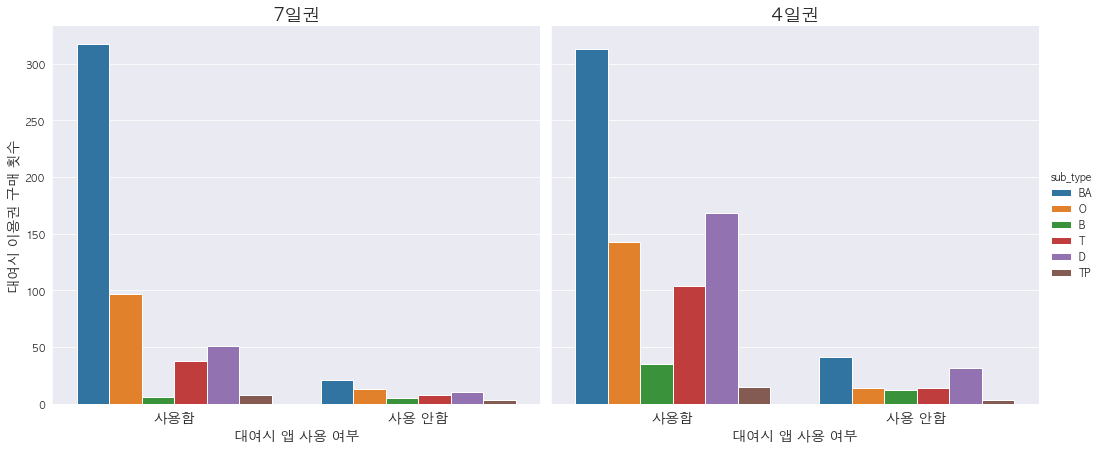

In [9]:
g=sns.catplot(x="app_yn", hue="sub_type", col="p_type", data=data, kind="count", height=6, aspect=1.2)
axes = g.axes.flatten()
axes[0].set_title("7일권", fontsize=18)
axes[1].set_title("4일권", fontsize=18)

g.set_ylabels('대여시 이용권 구매 횟수', fontsize=14)
g.set_xticklabels(['사용함', '사용 안함'], fontsize=14)
g.set_xlabels('대여시 앱 사용 여부', fontsize=14);

# ✍🏻 Analysis   
## 1️⃣ 대여 주문(구매) 소요 시간 분석 : 코호트 분석
- 가입일을 기준으로 코호트화 하였으며 **데이터셋의 한계로 기존의 리텐션 개념과는 다르게 해당 주차별 대여 주문 건수를 카운트하여 대여 주문 유지율을 계산함** 
  
### 분석을 위한 EDA (1) : 가입 날짜에 따른 대여 횟수   
- 신규 유저의 대여가 활발  
- 주어진 데이터셋으로는 기존 유저와 신규 유저를 비교하기에는 무리가 있음 

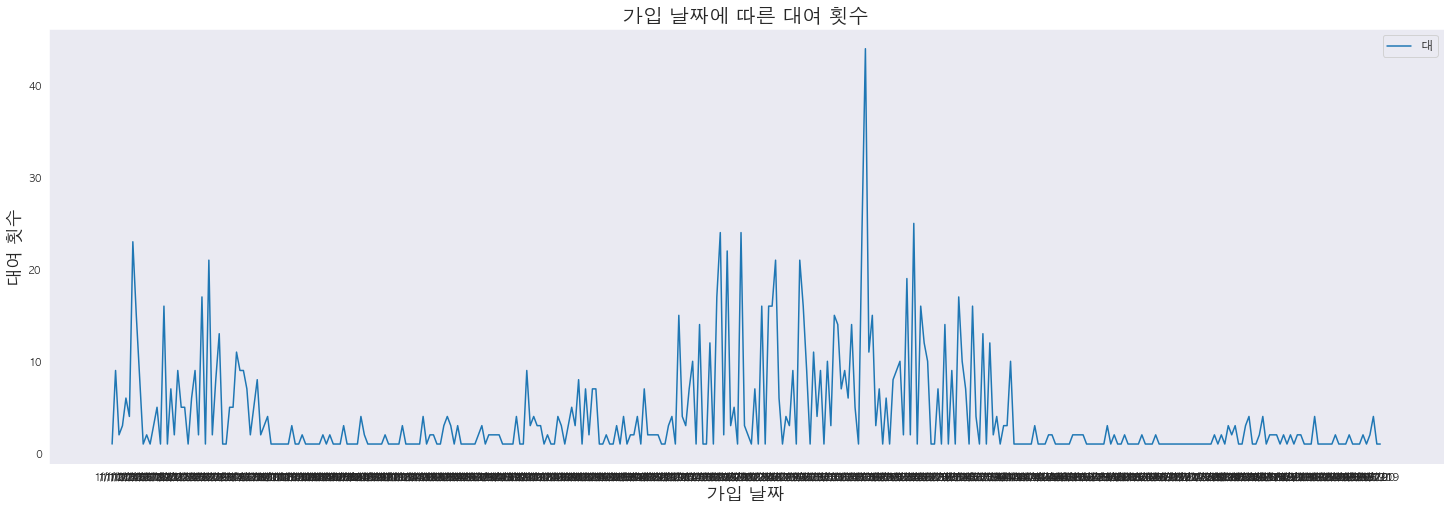

In [10]:
reg_time = data.groupby(data['reg_date'])['goodsnm'].count()
plt.figure(figsize=(25,8))
sns.lineplot(reg_time.index, reg_time.values)
plt.grid(linewidth=1)
plt.legend('대여 횟수',loc='best', fontsize=12)
plt.title('가입 날짜에 따른 대여 횟수', fontsize=20)
plt.ylabel('대여 횟수', fontsize=18)
plt.xlabel('가입 날짜', fontsize=18)
plt.show();

### 분석을 위한 EDA (2) : 최근 3개월 간 대여 횟수  
- 주기성 확인 가능

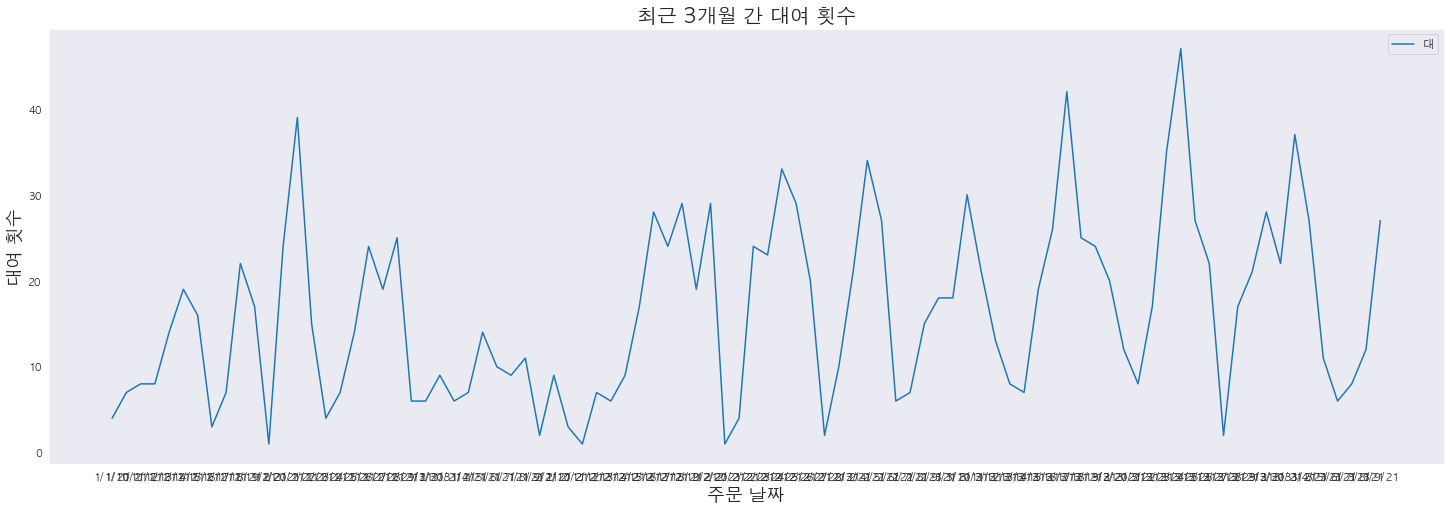

In [11]:
order_time = data.groupby(data['order_date'])['goodsnm'].count()
plt.figure(figsize=(25,8))
sns.lineplot(order_time.index, order_time.values)
plt.grid(linewidth=1)
plt.legend('대여 횟수',loc='best', fontsize=11)
plt.title('최근 3개월 간 대여 횟수', fontsize=20)
plt.ylabel('대여 횟수', fontsize=18)
plt.xlabel('주문 날짜', fontsize=18)
plt.show();

### 분석을 위한 EDA (3) : 요일별 대여 횟수 살펴보기
- 월요일부터 수요일까지 증가하다가 목요일부터 감소
- 주말에는 평일보다 대여 횟수가 현저히 적음

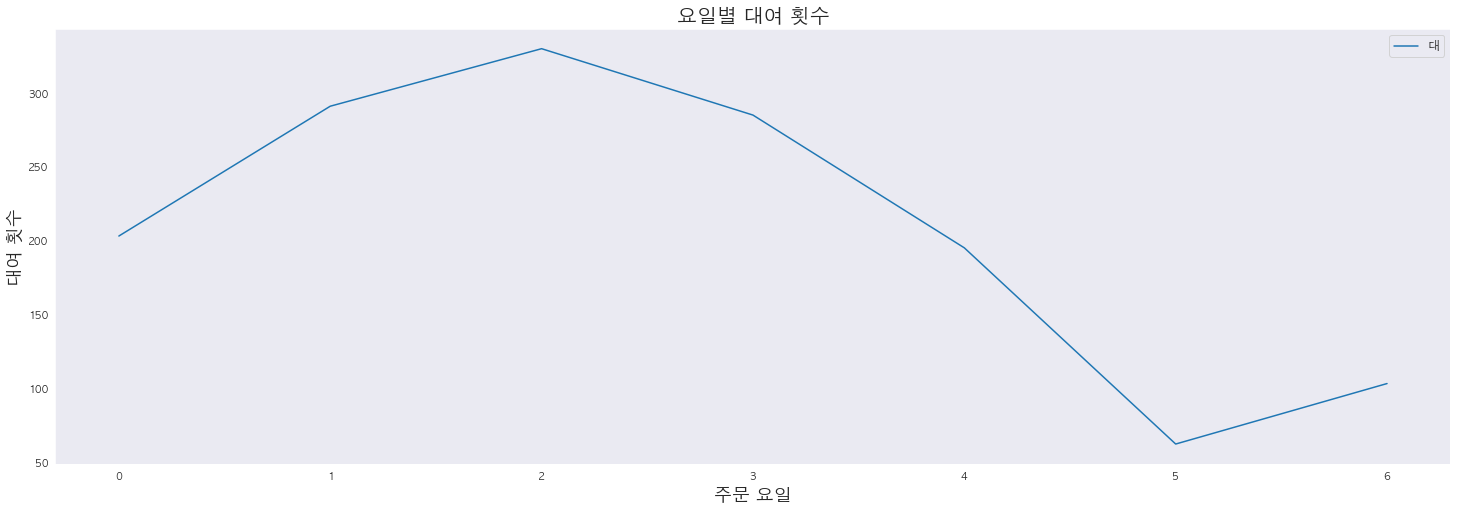

In [12]:
data['order_date'] = pd.to_datetime(data['order_date'])
data['order_month'] = [k for k in data['order_date'].dt.month]
data['order_day'] = [k for k in data['order_date'].dt.day]
data['order_dayofweek'] = [k for k in data['order_date'].dt.dayofweek]

week_order = data.groupby(data['order_dayofweek'])['brandnm'].count()
plt.figure(figsize=(25,8))
sns.lineplot(week_order.index, week_order.values)
plt.grid(linewidth=1)
plt.legend('대여 횟수',loc='best', fontsize=12)
plt.title('요일별 대여 횟수', fontsize=20)
plt.ylabel('대여 횟수', fontsize=18)
plt.xlabel('주문 요일', fontsize=18)
plt.show();

### 구매 소요 시간 분석 (1)-1 : 기존 고객들의 월별 코호트 분석    
- 그래프 읽기  
> 각 행을 기준으로 처음 구매한 건수를 100으로 보고 이후 몇 배 증가 혹은 감소했는지 숫자로 표현.  
> 예를 들어 가장 아랫줄의 경우 2020년 12월에 가입한 고객들의 2021년 1월 구매 건수를 100이라고 볼 때 2월에는 28.3으로 줄었고 3월에는 20.8로 줄었음 
- 19, 20년도 가입자들의 구매 리텐션은 꽤 유지되고 있음.  
- 하지만, 17, 18년도 가입자들의 구매 리텐션은 상당히 낮은 것을 확인할 수 있음.

In [13]:
# 가입날짜 - 그 해, 그 달 n주차 가입 
data['reg_date'] = pd.to_datetime(data['reg_date'])
data['reg_date_ym']=data['reg_date'].dt.strftime('%y-%m')
data['reg_date_w']='NaN'

#당월 n주차 구하는 함수 
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

#당월 n주차 구하기
for idx, (y, m, n) in enumerate(zip(data.reg_date.dt.year, data.reg_date.dt.month, data.reg_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    data['reg_date_w'].iloc[idx]= temp_week

#가입일의 연도-월-n주차 
data['reg_date_ymw']=data.reg_date_ym+'-'+data.reg_date_w.astype(str)

# 주문날짜 - 그 해, 그 달 n주차 구매
data['order_date_ym']=data['order_date'].dt.strftime('%y-%m')
data['order_date_w']='NaN'

for idx, (y, m, n) in enumerate(zip(data['order_date'].dt.year, data['order_date'].dt.month, data['order_date'].dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    data['order_date_w'].iloc[idx]= temp_week

data['order_date_ymw']=data['order_date_ym']+'-'+data['order_date_w'].astype(str)

In [14]:
#가입 연도와 월, 주문 연도와 월 
data['reg_Month'] = data['reg_date'].apply(lambda x : datetime(x.year, x.month, 1)) 
data['order_Month'] = data['order_date'].apply(lambda x : datetime(x.year, x.month, 1)) 

#기존 고객// 신규 고객 분리 
origin = data[data['reg_date']<'2021-01-01']
new = data[data['reg_date']>='2021-01-01']

#기존 고객들의 월별 코호트 분석 
cohort_group = origin.groupby(['reg_Month', 'order_Month'])
cohort_df = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_df = cohort_df.pivot(index='reg_Month', columns = 'order_Month')
customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100 # 백분율로 표현
customer_cohort = customer_cohort.round(decimals=2)

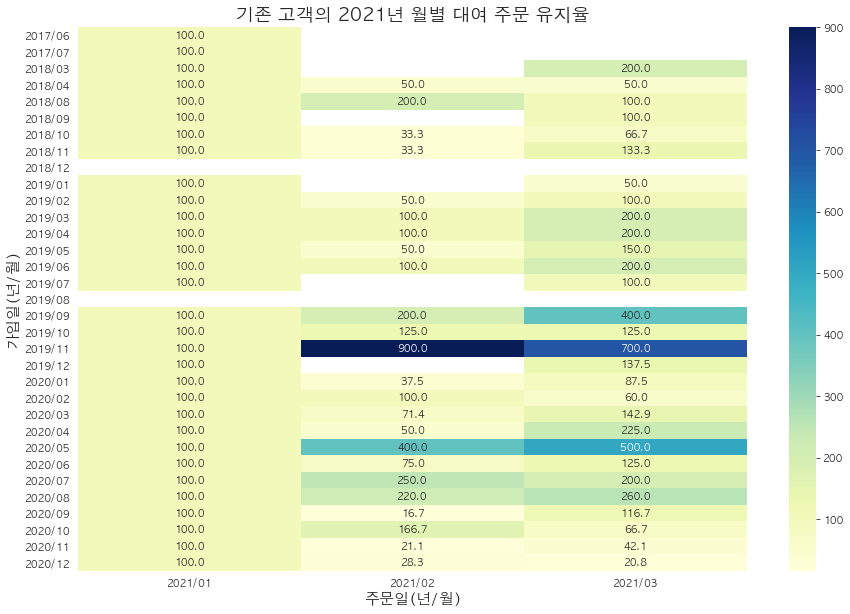

In [15]:
sns.set_style(style="whitegrid")
plt.rcParams['font.family']='AppleGothic'

xticks = ['2021/01', '2021/02', '2021/03']
yticks = ['2017/06','2017/07','2018/03','2018/04','2018/08','2018/09','2018/10','2018/11','2018/12',
          '2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12',
          '2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12']
         

plt.figure(figsize = (15,10))
plt.title('기존 고객의 2021년 월별 대여 주문 유지율', fontsize=18)
sns.heatmap(customer_cohort,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,            
           fmt = '.1f',
           cmap = 'YlGnBu')
plt.ylabel('가입일(년/월)', fontsize=15)
plt.xlabel('주문일(년/월)', fontsize=15);

### 구매 소요 시간 분석 (1)-2 : 기존 고객들의 주차별 코호트 분석    
- 마찬가지로 비교적 최근(19,20년도)에 가입한 유저들의 리텐션이 유지되고 있음.

In [16]:
def get_unique_no(x):
    return len(np.unique(x))
cohort_group = data.groupby(['reg_date_ym', 'order_date_ymw'])
cohort_df = cohort_group['USER'].apply(get_unique_no).reset_index()
cohort_old = cohort_df[cohort_df['reg_date_ym']<'21-01']
cohort_old_pivot = cohort_old.pivot(index='reg_date_ym', columns = 'order_date_ymw')

div_num=[]
for i in range(cohort_old_pivot.shape[0]):
    for j in range(cohort_old_pivot.shape[1]):
        if pd.isna(cohort_old_pivot.iloc[i][j])==False:
            first=cohort_old_pivot.iloc[i][j]
            div_num.append(first)
            break
cohort_old_pivot = cohort_old_pivot.div(div_num, axis=0) * 100

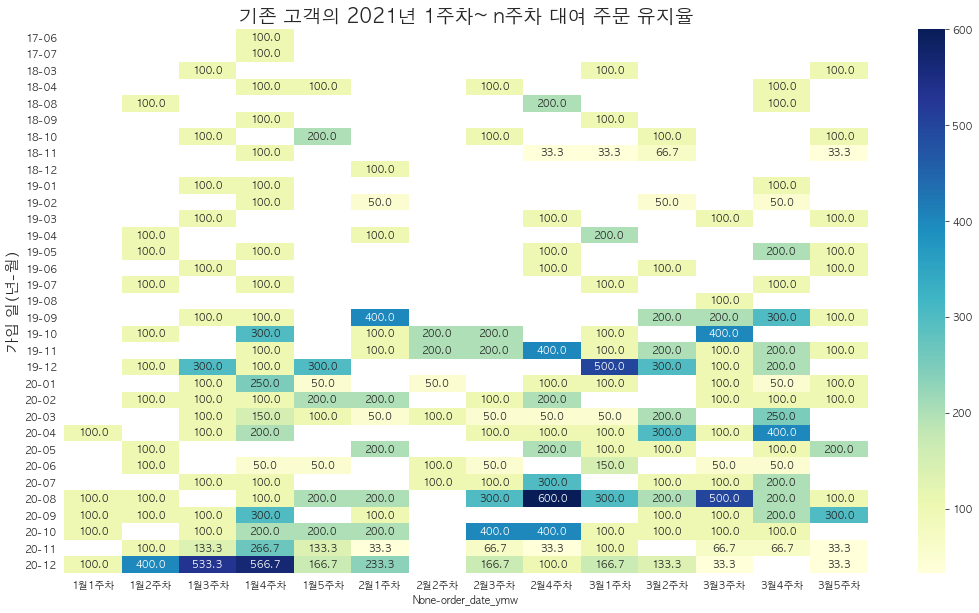

In [17]:
xticks = [(str(k[1][4])+'월'+ str(k[1][6]) + '주차') for k in cohort_old_pivot.columns]

plt.figure(figsize=(18, 10))
plt.title('기존 고객의 2021년 1주차~ n주차 대여 주문 유지율', fontsize=19)
sns.heatmap(cohort_old_pivot, annot=True, fmt = '.1f', xticklabels = xticks, cmap='YlGnBu')
plt.ylabel('가입 일(년-월)', fontsize=15)
plt.show();

### 구매 소요시간 분석 (2)-1 : 신규 유저들의 월별 코호트 분석  
- 신규유저(21년도 가입)들의 리텐션은 가입한 월에 비해 지속적으로 낮아지고 있음

In [18]:
cohort_group2 = new.groupby(['reg_Month', 'order_Month'])
cohort_df2 = cohort_group2['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_df2 = cohort_df2.pivot(index='reg_Month', columns = 'order_Month')
for i in range(3):
    first = cohort_df2.iloc[i][i]
    for j in range(3):
        cohort_df2.iloc[i][j] = cohort_df2.iloc[i][j]/first *100

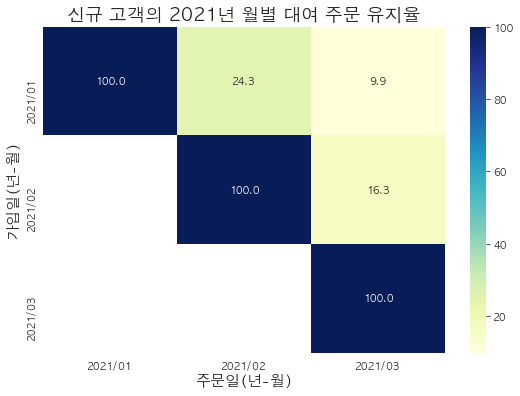

In [19]:
xticks = ['2021/01', '2021/02', '2021/03']
yticks = ['2021/01', '2021/02', '2021/03']

plt.figure(figsize = (9,6))
plt.title('신규 고객의 2021년 월별 대여 주문 유지율', fontsize=18)
sns.heatmap(cohort_df2,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,            
           fmt = '.1f',
           cmap = 'YlGnBu')
plt.ylabel('가입일(년-월)', fontsize=15)
plt.xlabel('주문일(년-월)', fontsize=15);

### 구매 소요시간 분석 (2)-2 : 신규 유저들의 주차별 코호트 분석    
- 몇몇 주차를 제외하고 가입시점 기준, 일주일 뒤부터 리텐션이 급속히 줄어드는 것을 확인할 수 있음.  
- 2주 이상으로 유저들의 리텐션을 끌어올릴 수 있는 방안이 필요해 보임.

In [20]:
cohort_group = data.groupby(['reg_date_ymw', 'order_date_ymw'])
cohort_df = cohort_group['USER'].apply(get_unique_no).reset_index()
cohort_new = cohort_df[cohort_df.reg_date_ymw>='21-01-1'] #신규 고객만
cohort_new_pivot = cohort_new.pivot(index='reg_date_ymw', columns = 'order_date_ymw')
for i in range(len(cohort_new_pivot)):
    first = cohort_new_pivot.iloc[i][i]
    for j in range(len(cohort_new_pivot)):
        cohort_new_pivot.iloc[i][j] = cohort_new_pivot.iloc[i][j]/first *100

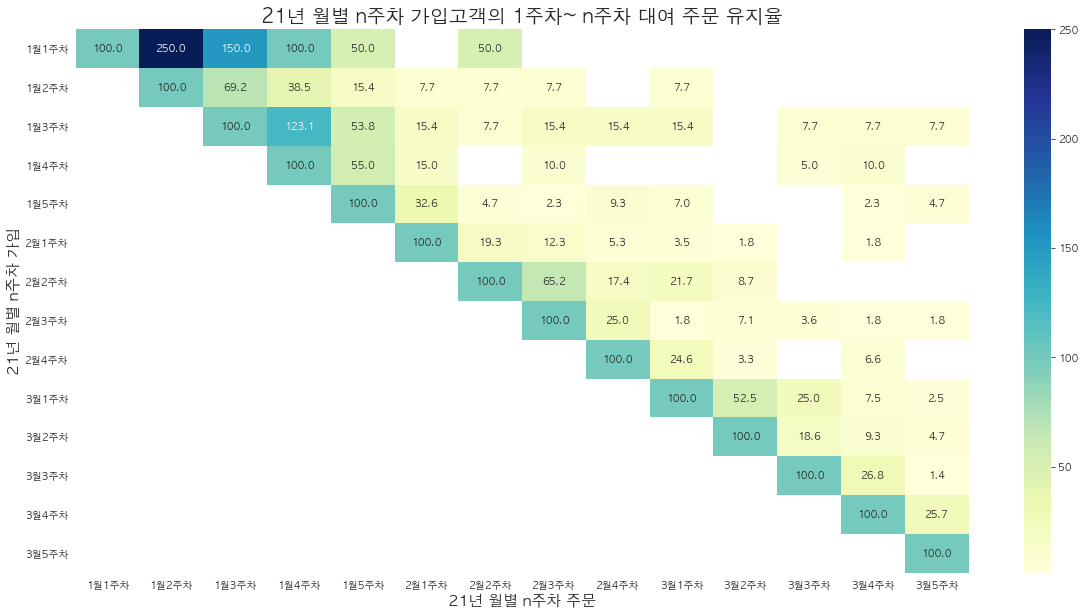

In [21]:
xticks = [(str(k[1][4])+'월'+ str(k[1][6]) + '주차') for k in cohort_new_pivot.columns]
yticks = [(str(k[4])+'월'+ str(k[6]) + '주차') for k in cohort_new_pivot.index]

plt.figure(figsize = (20,10))
plt.title('21년 월별 n주차 가입고객의 1주차~ n주차 대여 주문 유지율', fontsize=19)
sns.heatmap(cohort_new_pivot,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks, 
           fmt = '.1f',
           cmap = 'YlGnBu')
plt.ylabel('21년 월별 n주차 가입', fontsize=15)
plt.xlabel('21년 월별 n주차 주문', fontsize=15);

### 구매 소요 시간 분석 (2)-3 : 신규유저들의 1월의 일별 코호트 분석  
- 1월에 가입, 구매한 유저 152명  
- 가입한지 하루안에 구매자로 전환된 유저들이 다량 관측. (39개 그룹)  
- 하지만 전환 이후 신규유저들의 리텐션을 유지할 필요가 있음

In [22]:
new_day = new[:]
cohort_group = new_day.groupby(['reg_date', 'order_date'])
cohort_1M = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_1M = cohort_1M[cohort_1M['order_date']<'2021-02']
cohort_1M = cohort_1M.pivot(index='reg_date', columns = 'order_date')

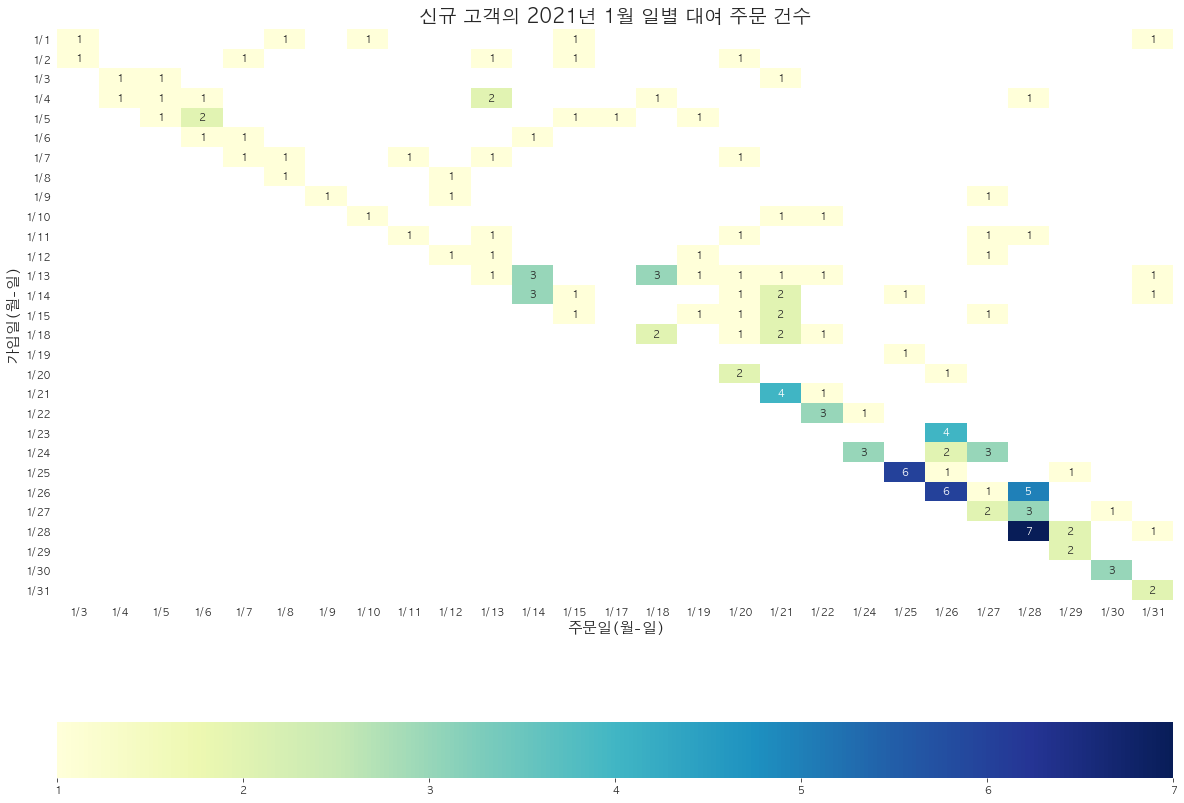

In [23]:
xticks = [(str(k[1].month)+'/'+ str(k[1].day)) for k in cohort_1M.columns]
yticks = [(str(k.month)+'/'+ str(k.day)) for k in cohort_1M.index]

plt.figure(figsize = (20,15))
plt.title('신규 고객의 2021년 1월 일별 대여 주문 건수', fontsize=19)
sns.heatmap(cohort_1M,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,
           cbar_kws={"orientation": "horizontal"},
           fmt = '.0f',
           cmap = 'YlGnBu')
plt.ylabel('가입일(월-일)', fontsize=15)
plt.xlabel('주문일(월-일)', fontsize=15);

### 구매 소요 시간 분석 (2)-4 : 신규유저들의 1월의 일별 코호트 분석   
- 2월에 가입, 구매한 유저는 251명. (1월에 비해 65% 증가)
- 1월과 마찬가지로 가입한지 하루안에 구매자로 전환된 유저들이 다량 관측. (43개 그룹으로 1월에 비해 10% 증가)
- 1월에 비해 유저들의 리텐션이 유지되고 있음.

In [24]:
new_day = new[:]
cohort_group = new_day.groupby(['reg_date', 'order_date'])
cohort_2M = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_2M = cohort_2M[cohort_2M['reg_date']<'2021-03']
cohort_2M = cohort_2M[cohort_2M['reg_date']>'2021-01-31']
cohort_2M = cohort_2M[cohort_2M['order_date']<'2021-03']
cohort_2M = cohort_2M.pivot(index='reg_date', columns = 'order_date')

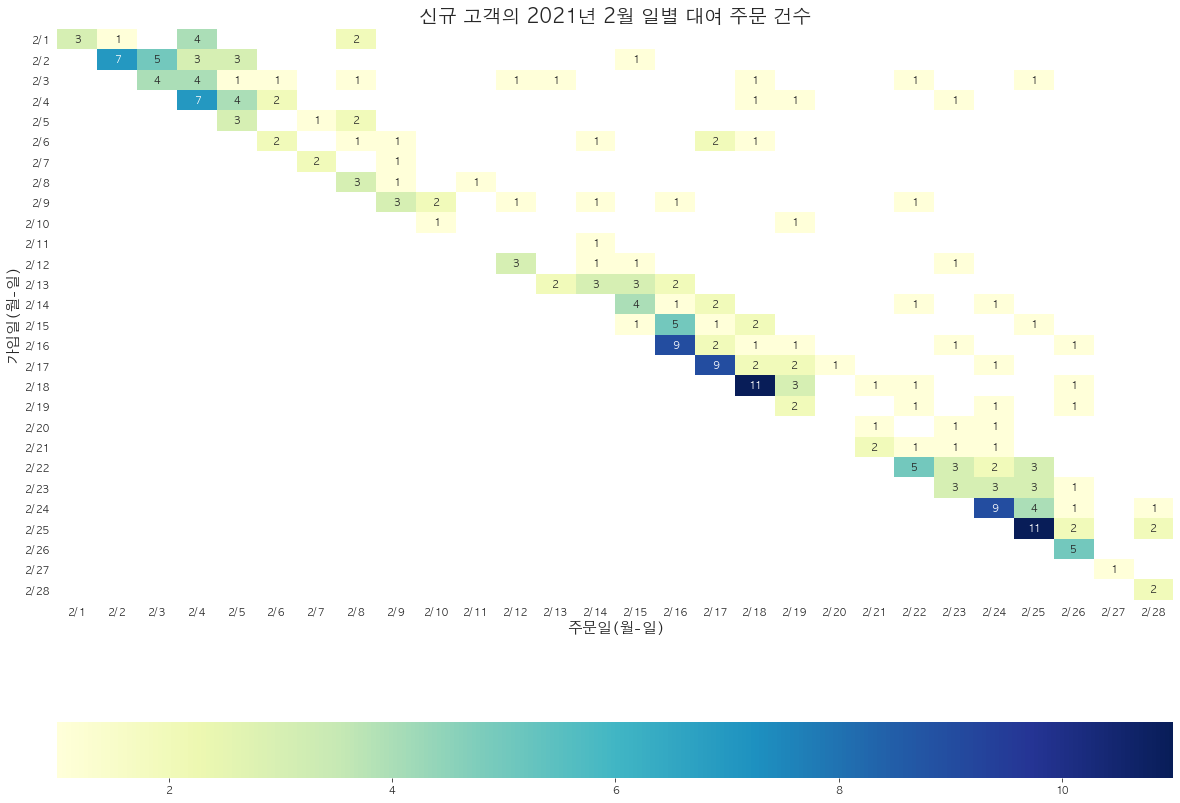

In [25]:
xticks = [(str(k[1].month)+'/'+ str(k[1].day)) for k in cohort_2M.columns]
yticks = [(str(k.month)+'/'+ str(k.day)) for k in cohort_2M.index]

plt.figure(figsize = (20,15))
plt.title('신규 고객의 2021년 2월 일별 대여 주문 건수', fontsize=19)
sns.heatmap(cohort_2M,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,
           cbar_kws={"orientation": "horizontal"},
           fmt = '.0f',
           cmap = 'YlGnBu')
plt.ylabel('가입일(월-일)', fontsize=15)
plt.xlabel('주문일(월-일)', fontsize=15);

###  구매 소요 시간 분석 (2)-5 : 신규유저들의 1월의 일별 코호트 분석  
- 3월에 가입, 구매한 유저는 339명.(2월에 비해 35% 증가)
- 다달이 가입, 구매 유저가 증가하고 있음.
- 1, 2월과 마찬가지로 가입한지 하루안에 구매자로 전환된 유저들이 다량 관측.(51개 그룹으로 2월에 비해 18%증가)
- 유저들의 리텐션이 점차 유지되고 있으나 일주일정도가 고비로 보임.
- 따라서, 유저들의 리텐션을 일주일 이상 유지하기 위한 전략이 필요.

In [26]:
new_day = new[:]
cohort_group = new_day.groupby(['reg_date', 'order_date'])
cohort_3M = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_3M = cohort_3M[cohort_3M['reg_date']>'2021-02-28']
cohort_3M = cohort_3M[cohort_3M['order_date']>'2021-02-28']
cohort_3M = cohort_3M.pivot(index='reg_date', columns = 'order_date')

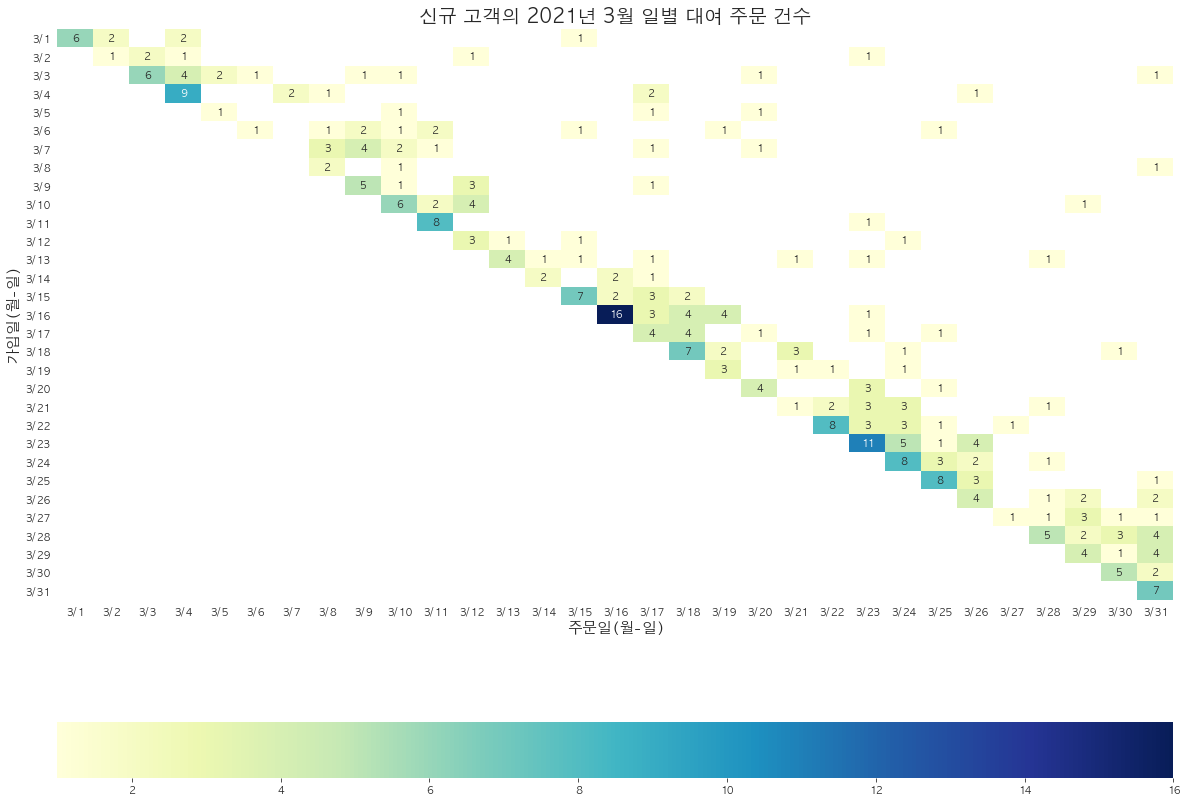

In [27]:
xticks = [(str(k[1].month)+'/'+ str(k[1].day)) for k in cohort_3M.columns]
yticks = [(str(k.month)+'/'+ str(k.day)) for k in cohort_3M.index]

plt.figure(figsize = (20,15))
plt.title('신규 고객의 2021년 3월 일별 대여 주문 건수', fontsize=19)
sns.heatmap(cohort_3M,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,
           cbar_kws={"orientation": "horizontal"},
           fmt = '.0f',
           cmap = 'YlGnBu')
plt.ylabel('가입일(월-일)', fontsize=15)
plt.xlabel('주문일(월-일)', fontsize=15);

## 2️⃣ 대여 상품 트렌드 분석  : 유저별, 아이템별 분석 
### 유저별 분석 (1) : 유저별 대여 현황 
- 50개의 유저가 2개 이상 주문

In [28]:
data['month'] = data['order_date'].dt.month
data['day'] =  data['order_date'].dt.day

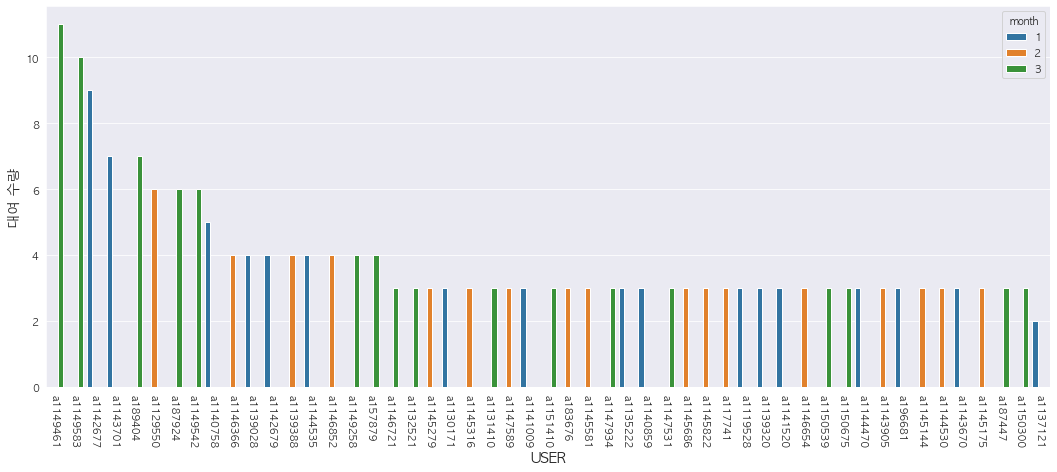

In [29]:
sns.set_style(style="darkgrid")
plt.rcParams['font.family']='AppleGothic'

df_cross = pd.crosstab(data['USER'], data['month'])
df_cross['sum']= df_cross.sum(axis=1)
df_cross = df_cross.sort_values('sum', ascending=False)
df_cross['month'] = 0
for i in range(df_cross.shape[0]):
    if df_cross.iloc[i, 0]!=0:
        df_cross.iloc[i,-1]= 1
    elif df_cross.iloc[i, 1]!=0:
        df_cross.iloc[i,-1]= 2
    elif df_cross.iloc[i, 2]!=0:
        df_cross.iloc[i,-1]= 3
plt.figure(figsize=(18,7))
sns.barplot(data=df_cross[:51],x=df_cross.index[:51],  y=df_cross.iloc[:51, :]['sum'],hue='month')
plt.ylabel('대여 수량', fontsize=14)
plt.xlabel('USER', fontsize=14)
plt.xticks(rotation=270)
plt.show();

###  유저별 분석 (2) : 2021년 주차별 대여 현황  
- 1, 2월에 비해 3월에 더 증가한 것을 볼 수 있음 

In [30]:
# 필요없는 column 드랍
drop_cols=['reg_date_ym','reg_date_w','order_date_w','order_date_ym','order_date_w','reg_date_w']
temp = data.drop(drop_cols, 1)
order = temp.groupby('order_date_ymw').count()['USER'].reset_index()

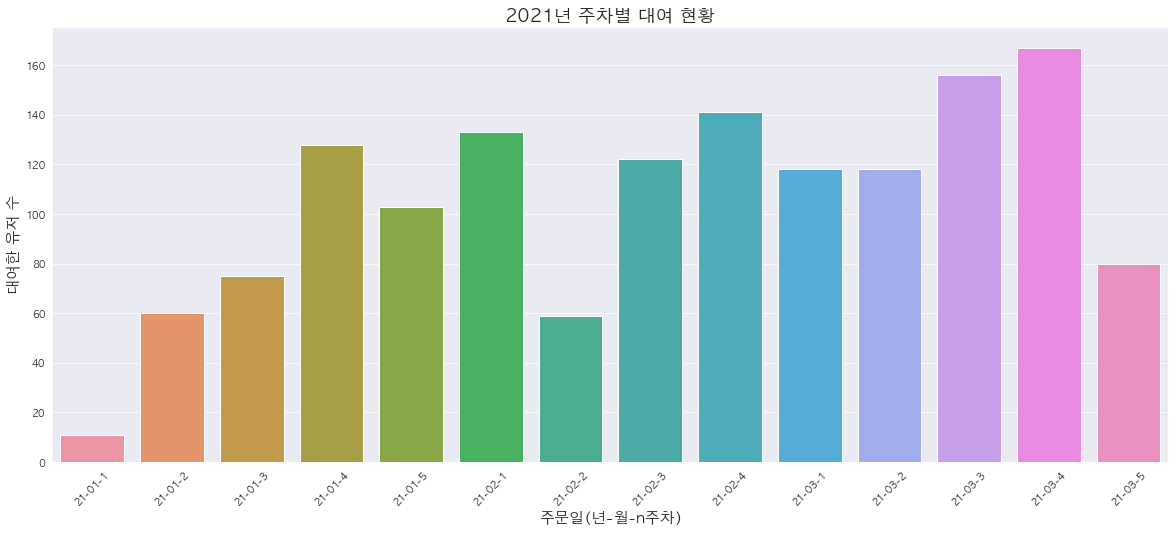

In [31]:
figure = plt.figure(figsize=(20,8))
sns.barplot(data=order, x='order_date_ymw', y='USER')
plt.xticks(rotation = 45)
plt.title('2021년 주차별 대여 현황', fontsize=18)
plt.ylabel('대여한 유저 수',fontsize=15)
plt.xlabel('주문일(년-월-n주차)',fontsize=15)
plt.show();

###  유저별 분석 (3) : 2021년 월별 대여 현황

In [32]:
sub_type = {'O':'아우터', 'T':'상의', 'B':'하의', 'TP':'투피스', 'D':'드레스', 'BA':'가방'}
def sub_type_map(x):
    return sub_type[x]
data['타입']= data['sub_type'].map(sub_type_map)

## 월별 dataframe
df_month1 = data[data['month']==1].sort_values('day')
df_month2 = data[data['month']==2].sort_values('day')
df_month3 = data[data['month']==3].sort_values('day')

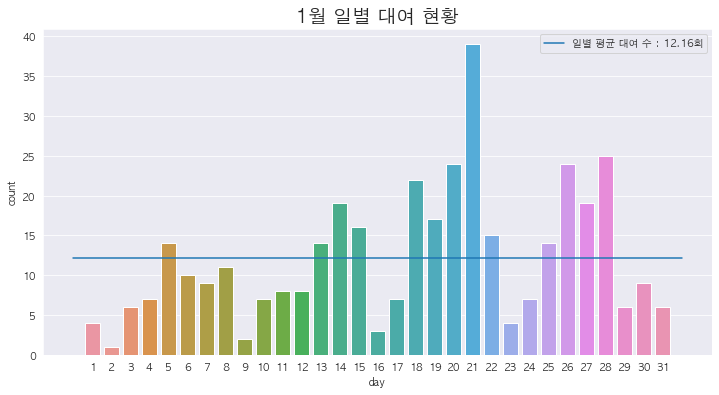

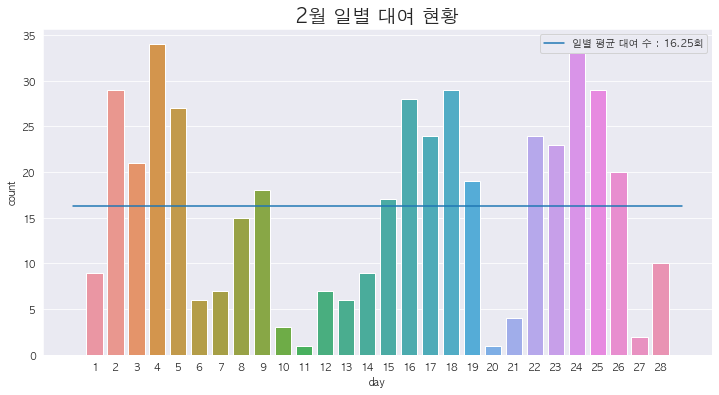

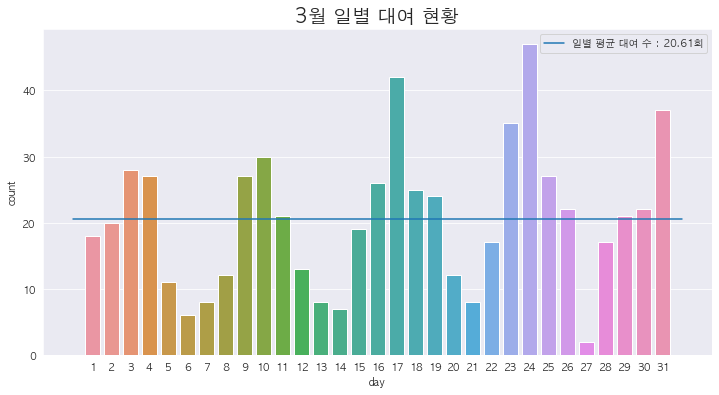

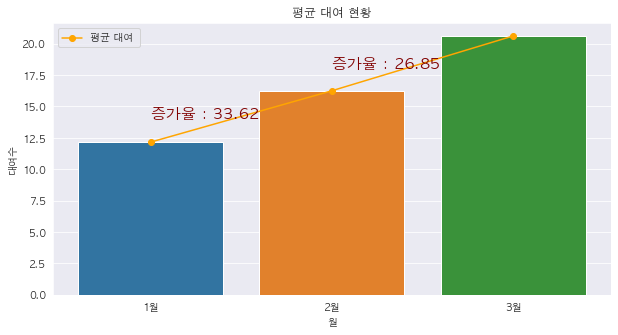

In [33]:
# 월별 figure
plt.figure(figsize=(12,6))
m1 = df_month1.groupby('day').count()['goodsnm'].mean()
sns.countplot(data=df_month1, x ='day')
plt.plot(range(-1, 32), 33*[m1], label =f'일별 평균 대여 수 : {round(m1,2)}회')
plt.title('1월 일별 대여 현황', fontsize=19)
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
m2 = df_month2.groupby('day').count()['goodsnm'].mean()
sns.countplot(data=df_month2, x ='day')
plt.plot(range(-1, 29), 30*[m2], label =f'일별 평균 대여 수 : {round(m2,2)}회')
plt.title('2월 일별 대여 현황', fontsize=19)
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
m3 = df_month3.groupby('day').count()['goodsnm'].mean()
sns.countplot(data=df_month3, x ='day')
plt.plot(range(-1, 32), 33*[m3], label =f'일별 평균 대여 수 : {round(m3,2)}회')
plt.title('3월 일별 대여 현황', fontsize=19)
plt.legend()
plt.show()

# 평균 dataframe
df_mean = pd.DataFrame(data = [[m1, m2, m3] ], columns=['1월', '2월', '3월'], index=['평균'])

# 월별 변화량 그래프
val1 = round((df_mean.loc['평균', '2월']/df_mean.loc['평균', '1월'] -1) * 100, 2)
val2 = round((df_mean.loc['평균', '3월']/df_mean.loc['평균', '2월'] -1) * 100, 2)
plt.figure(figsize=(10,5))
sns.barplot(data=df_mean.loc[['평균'], :])
plt.plot(df_mean.columns, df_mean.loc['평균'], 'o-',color='orange', label='평균 대여 ')
plt.text(0., 14, f'증가율 : {val1}', fontsize=15, color ='maroon')
plt.text(1, 18, f'증가율 : {val2}', fontsize=15, color ='maroon')

plt.xlabel('월')
plt.ylabel('대여수')
plt.title('평균 대여 현황')
plt.legend()
plt.show()

###  유저별 분석 (4) : p_type별 월별 대여 현황   
- 4일권이 7일권보다 이용률이 높음  
- 4일권, 7일권 이용권 모두 21년 1~3월 동안 절대 수치는 증가하고 있으나 증가율은 감소함 

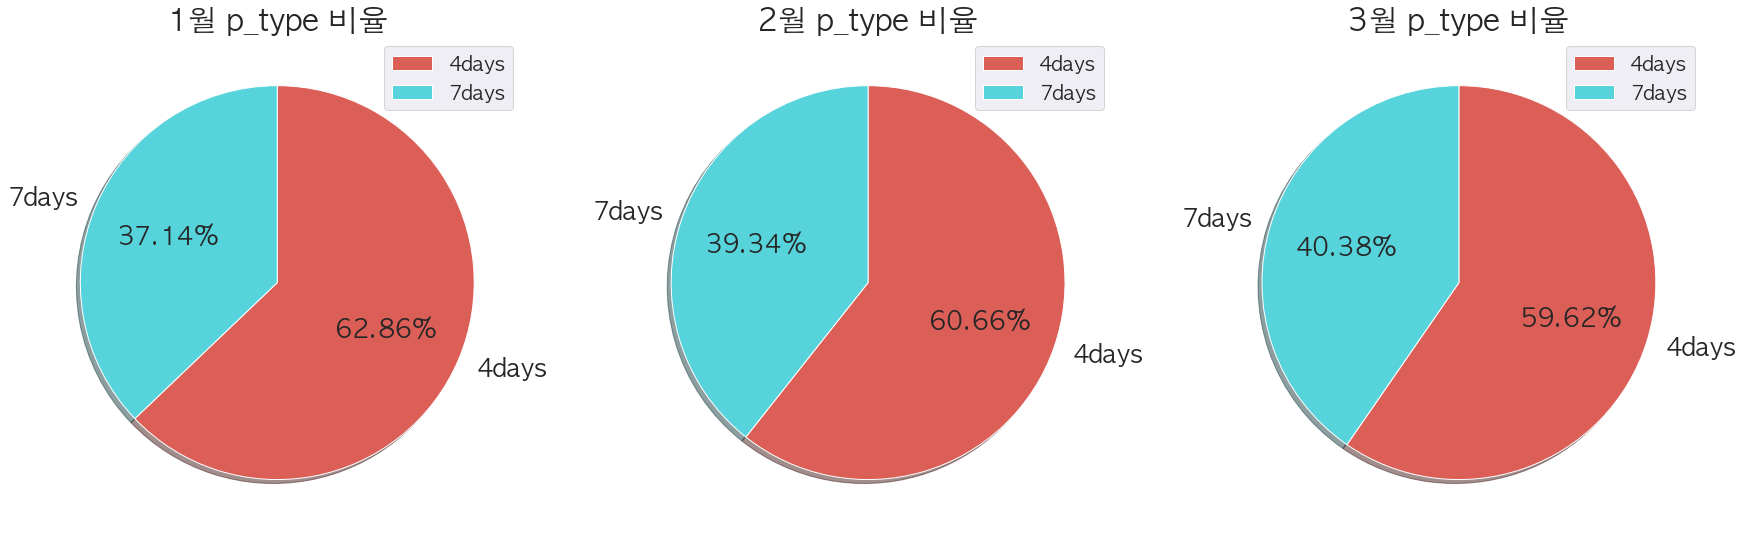

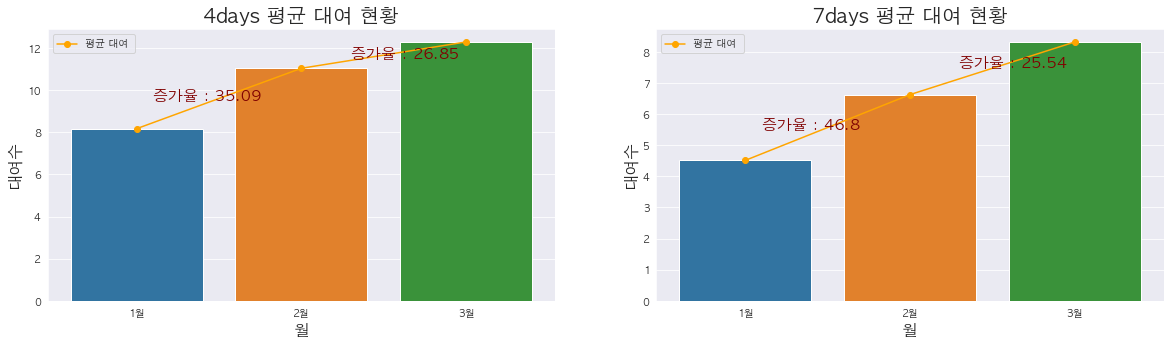

In [34]:
## month/p_type 별 dataframe
df_month1_4days = df_month1[df_month1['p_type']=='4days'].sort_values('day')
df_month1_7days = df_month1[df_month1['p_type']=='7days'].sort_values('day')

df_month2_4days = df_month2[df_month2['p_type']=='4days'].sort_values('day')
df_month2_7days = df_month2[df_month2['p_type']=='7days'].sort_values('day')

df_month3_4days = df_month3[df_month3['p_type']=='4days'].sort_values('day')
df_month3_7days = df_month3[df_month3['p_type']=='7days'].sort_values('day')



# 평균 dataframe
m14 = (df_month1[df_month1['p_type']=='4days'].groupby('day').count()['goodsnm'].mean())
m17 = (df_month1[df_month1['p_type']=='7days'].groupby('day').count()['goodsnm'].mean())

m24 = (df_month2[df_month2['p_type']=='4days'].groupby('day').count()['goodsnm'].mean())
m27 = (df_month2[df_month2['p_type']=='7days'].groupby('day').count()['goodsnm'].mean())

m34 = (df_month3[df_month3['p_type']=='4days'].groupby('day').count()['goodsnm'].mean())
m37 = (df_month3[df_month3['p_type']=='7days'].groupby('day').count()['goodsnm'].mean())

df_mean.loc['4days 평균', ['1월', '2월', '3월']] = [m14, m24, m34]
df_mean.loc['7days 평균', ['1월', '2월', '3월']] = [m17, m27, m37]


## 파이 차트
labels = ['4days', '7days']
colors = sns.color_palette('hls', len(labels))
fig = plt.figure(figsize=(30,10))
fig.set_facecolor('white')

fig.add_subplot(1,3,1)
frequency1 = [df_month1_4days.shape[0], df_month1_7days.shape[0]]
pie1 = plt.pie(frequency1, 
       startangle=90, 
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p), 
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('1월 p_type 비율', fontsize=30)

fig.add_subplot(1,3,2)
frequency2 = [df_month2_4days.shape[0], df_month2_7days.shape[0]]
pie2 = plt.pie(frequency2, 
       startangle=90,
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p), 
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('2월 p_type 비율', fontsize=30)

fig.add_subplot(1,3,3)
frequency3 = [df_month3_4days.shape[0], df_month3_7days.shape[0]]
pie3 = plt.pie(frequency3, 
       startangle=90, 
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p),
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('3월 p_type 비율', fontsize=30)
plt.show()


## 막대 그래프
fig = plt.figure(figsize=(20,5))
gs = GridSpec(1,2)
sns.barplot(data=df_mean.loc[['4days 평균'], :], ax = fig.add_subplot(gs[0,0]))
plt.plot(df_mean.columns, df_mean.loc['4days 평균'], 'o-', color='orange', label='평균 대여 ')
plt.xlabel('월', fontsize=16)
plt.ylabel('대여수', fontsize=16)
plt.title('4days 평균 대여 현황', fontsize=20)

val11 = round((df_mean.loc['4days 평균', '2월']/df_mean.loc['4days 평균', '1월'] -1) * 100, 2)
val12 = round((df_mean.loc['평균', '3월']/df_mean.loc['평균', '2월'] -1) * 100, 2)

plt.text(0.1, 9.5, f'증가율 : {val11}', fontsize=15, color ='maroon')
plt.text(1.3, 11.5, f'증가율 : {val12}', fontsize=15, color ='maroon')

plt.legend()

sns.barplot(data=df_mean.loc[['7days 평균'], :], ax = fig.add_subplot(gs[0,1]))
plt.plot(df_mean.columns, df_mean.loc['7days 평균'], 'o-', color='orange', label='평균 대여 ')
plt.xlabel('월', fontsize=16)
plt.ylabel('대여수', fontsize=16)

val21 = round((df_mean.loc['7days 평균', '2월']/df_mean.loc['7days 평균', '1월'] -1) * 100, 2)
val22 = round((df_mean.loc['7days 평균', '3월']/df_mean.loc['7days 평균', '2월'] -1) * 100, 2)

plt.text(0.1, 5.5, f'증가율 : {val21}', fontsize=15, color ='maroon')
plt.text(1.3, 7.5, f'증가율 : {val22}', fontsize=15, color ='maroon')
plt.title('7days 평균 대여 현황', fontsize=20)
plt.legend()

plt.show()

###  유저별 분석 (5) : 주문시 App/Web 월별 이용 현황  
- 앱을 이용한 구매가 웹사이트를 통한 구매보다 월등히 높음  
- 그러나 웹사이트를 통한 구매의 증가율이 증가하고 있으므로 웹사이트에 대한 개선도 필요하다고 판단됨

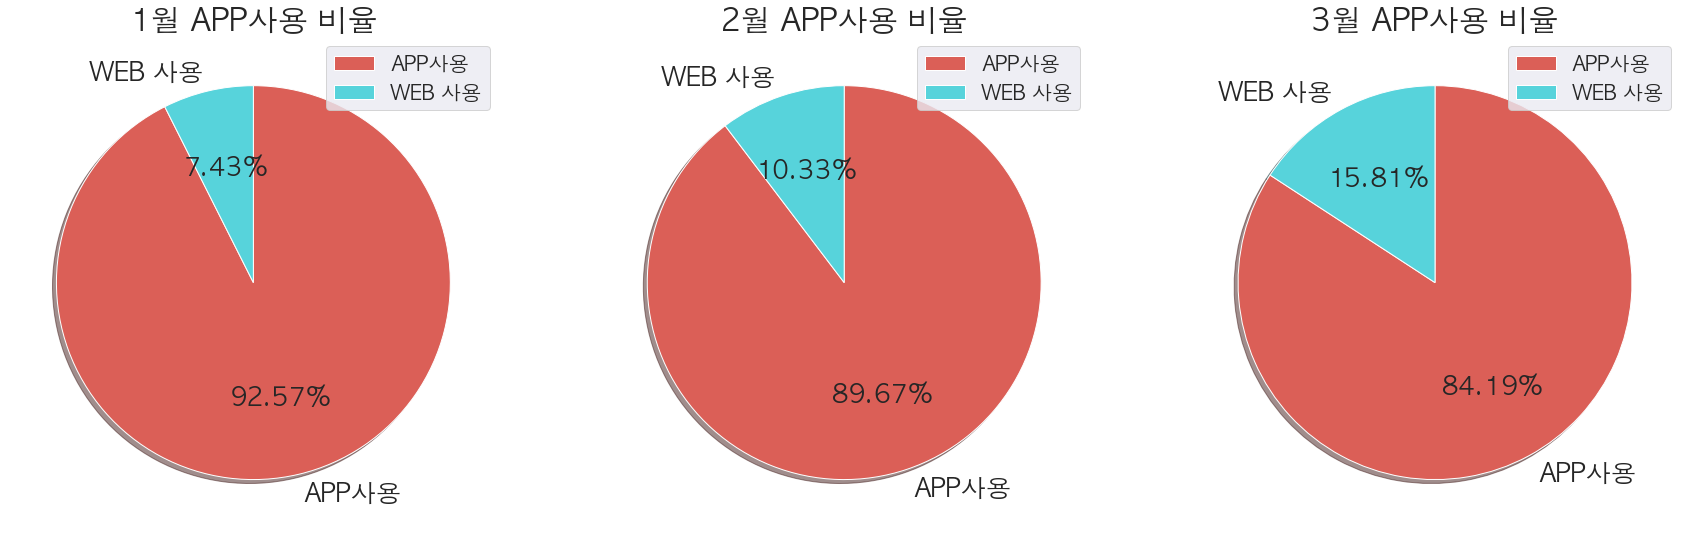

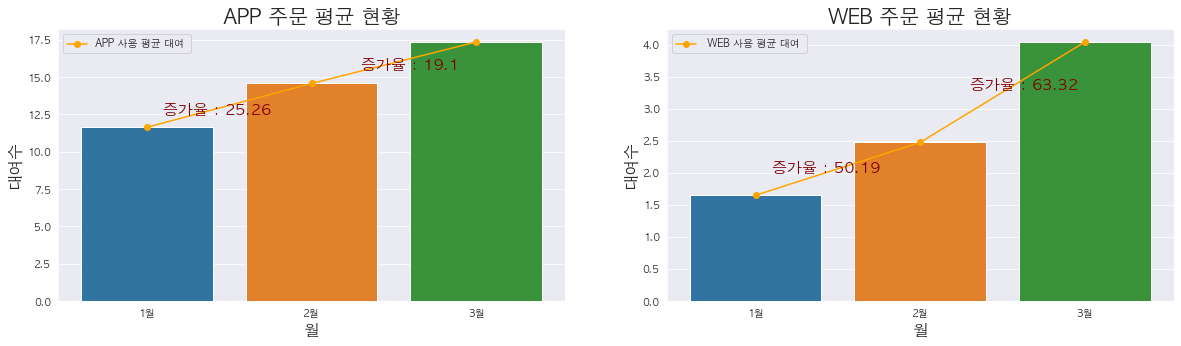

In [35]:
## app dataframe
df_month1_app = df_month1[df_month1['app_yn']=='Y'].sort_values('day')
df_month1_web = df_month1[df_month1['app_yn']=='N'].sort_values('day')

df_month2_app = df_month2[df_month2['app_yn']=='Y'].sort_values('day')
df_month2_web = df_month2[df_month2['app_yn']=='N'].sort_values('day')

df_month3_app = df_month3[df_month3['app_yn']=='Y'].sort_values('day')
df_month3_web = df_month3[df_month3['app_yn']=='N'].sort_values('day')


## 평균 dataframe
m1y = (df_month1[df_month1['app_yn']=='Y'].groupby('day').count()['goodsnm'].mean())
m1n = (df_month1[df_month1['app_yn']=='N'].groupby('day').count()['goodsnm'].mean())

m2y = (df_month2[df_month2['app_yn']=='Y'].groupby('day').count()['goodsnm'].mean())
m2n = (df_month2[df_month2['app_yn']=='N'].groupby('day').count()['goodsnm'].mean())

m3y = (df_month3[df_month3['app_yn']=='Y'].groupby('day').count()['goodsnm'].mean())
m3n = (df_month3[df_month3['app_yn']=='N'].groupby('day').count()['goodsnm'].mean())

df_mean.loc['APP 사용 평균', ['1월', '2월', '3월']] = [m1y, m2y, m3y]
df_mean.loc['WEB 사용 평균', ['1월', '2월', '3월']] = [m1n, m2n, m3n]


## 파이 차트
labels = ['APP사용', 'WEB 사용']
colors = sns.color_palette('hls', len(labels))
fig = plt.figure(figsize=(30,10))
fig.set_facecolor('white')

fig.add_subplot(1,3,1)
frequency1 = [df_month1_app.shape[0], df_month1_web.shape[0]]
pie1 = plt.pie(frequency1, 
       startangle=90, 
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p), 
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('1월 APP사용 비율', fontsize=30)

fig.add_subplot(1,3,2)
frequency2 = [df_month2_app.shape[0], df_month2_web.shape[0]]
pie2 = plt.pie(frequency2, 
       startangle=90,         
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p), 
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('2월 APP사용 비율', fontsize=30)

fig.add_subplot(1,3,3)
frequency3 = [df_month3_app.shape[0], df_month3_web.shape[0]]
pie3 = plt.pie(frequency3, 
       startangle=90,
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p),
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('3월 APP사용 비율', fontsize=30)
plt.show()


## 막대 그래프
fig = plt.figure(figsize=(20,5))
gs = GridSpec(1,2)
sns.barplot(data=df_mean.loc[['APP 사용 평균'], :], ax = fig.add_subplot(gs[0,0]))
plt.plot(df_mean.columns, df_mean.loc['APP 사용 평균'], 'o-', color='orange', label='APP 사용 평균 대여 ')
plt.xlabel('월', fontsize=16)
plt.ylabel('대여수', fontsize=16)
plt.title('APP 주문 평균 현황', fontsize=20)

val11 = round((df_mean.loc['APP 사용 평균', '2월']/df_mean.loc['APP 사용 평균', '1월'] -1) * 100, 2)
val12 = round((df_mean.loc['APP 사용 평균', '3월']/df_mean.loc['APP 사용 평균', '2월'] -1) * 100, 2)
plt.text(0.1, 12.5, f'증가율 : {val11}', fontsize=15, color ='maroon')
plt.text(1.3, 15.5, f'증가율 : {val12}', fontsize=15, color ='maroon')
plt.legend()

sns.barplot(data=df_mean.loc[['WEB 사용 평균'], :], ax = fig.add_subplot(gs[0,1]))
plt.plot(df_mean.columns, df_mean.loc['WEB 사용 평균'], 'o-', color='orange', label=' WEB 사용 평균 대여 ')
plt.xlabel('월', fontsize=16)
plt.ylabel('대여수', fontsize=16)
plt.title('WEB 주문 평균 현황', fontsize=20)

val21 = round((df_mean.loc['WEB 사용 평균', '2월']/df_mean.loc['WEB 사용 평균', '1월'] -1) * 100, 2)
val22 = round((df_mean.loc['WEB 사용 평균', '3월']/df_mean.loc['WEB 사용 평균', '2월'] -1) * 100, 2)
plt.text(0.1, 2, f'증가율 : {val21}', fontsize=15, color ='maroon')
plt.text(1.3, 3.3, f'증가율 : {val22}', fontsize=15, color ='maroon')
plt.legend()

plt.show()

###  아이템 분석 (1) : 제품 타입별 대여 현황  
- 가방과 아우터의 비중이 높음 

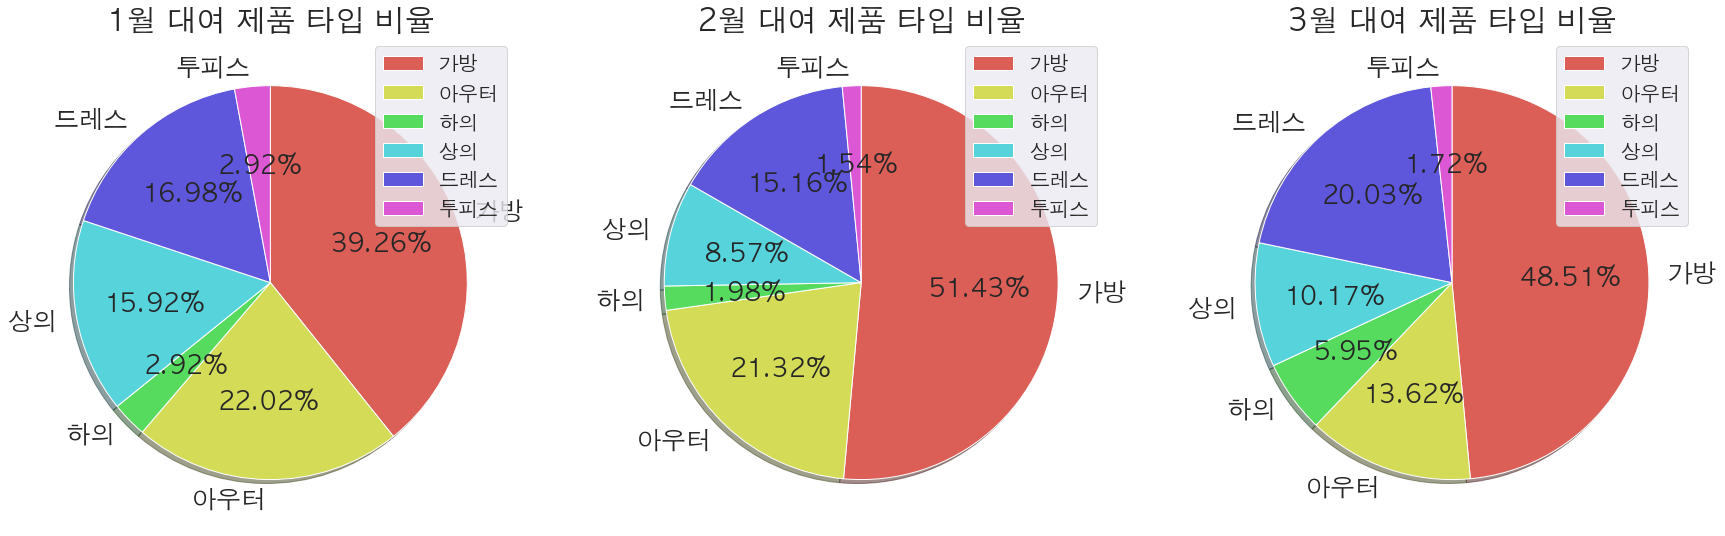

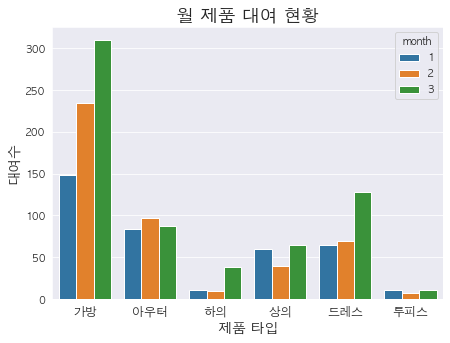

In [36]:
## 제품 dataframe
df_month1_ba = df_month1[df_month1['타입']=='가방'].sort_values('day')
df_month1_o = df_month1[df_month1['타입']=='아우터'].sort_values('day')
df_month1_b = df_month1[df_month1['타입']=='하의'].sort_values('day')
df_month1_t = df_month1[df_month1['타입']=='상의'].sort_values('day')
df_month1_d = df_month1[df_month1['타입']=='드레스'].sort_values('day')
df_month1_tp = df_month1[df_month1['타입']=='투피스'].sort_values('day')

df_month2_ba = df_month2[df_month2['타입']=='가방'].sort_values('day')
df_month2_o = df_month2[df_month2['타입']=='아우터'].sort_values('day')
df_month2_b = df_month2[df_month2['타입']=='하의'].sort_values('day')
df_month2_t = df_month2[df_month2['타입']=='상의'].sort_values('day')
df_month2_d = df_month2[df_month2['타입']=='드레스'].sort_values('day')
df_month2_tp = df_month2[df_month2['타입']=='투피스'].sort_values('day')

df_month3_ba = df_month3[df_month3['타입']=='가방'].sort_values('day')
df_month3_o = df_month3[df_month3['타입']=='아우터'].sort_values('day')
df_month3_b = df_month3[df_month3['타입']=='하의'].sort_values('day')
df_month3_t = df_month3[df_month3['타입']=='상의'].sort_values('day')
df_month3_d = df_month3[df_month3['타입']=='드레스'].sort_values('day')
df_month3_tp = df_month3[df_month3['타입']=='투피스'].sort_values('day')


## 파이차트
labels = ['가방', '아우터', '하의', '상의', '드레스', '투피스']
colors = sns.color_palette('hls', len(labels))
fig = plt.figure(figsize=(30,10))
fig.set_facecolor('white')

fig.add_subplot(1,3,1)
frequency1 = [df_month1_ba.shape[0], df_month1_o.shape[0], df_month1_b.shape[0], df_month1_t.shape[0], df_month1_d.shape[0], df_month1_tp.shape[0]]
pie1 = plt.pie(frequency1, 
       startangle=90, 
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p), 
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('1월 대여 제품 타입 비율', fontsize=30)

fig.add_subplot(1,3,2)
frequency2 = [df_month2_ba.shape[0], df_month2_o.shape[0], df_month2_b.shape[0], df_month2_t.shape[0], df_month2_d.shape[0], df_month2_tp.shape[0]]
pie2 = plt.pie(frequency2, 
       startangle=90,         
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p), 
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('2월 대여 제품 타입 비율', fontsize=30)

fig.add_subplot(1,3,3)
frequency3 = [df_month3_ba.shape[0], df_month3_o.shape[0], df_month3_b.shape[0], df_month3_t.shape[0], df_month3_d.shape[0], df_month3_tp.shape[0]]
pie3 = plt.pie(frequency3, 
       startangle=90,
       shadow=True, 
       counterclock=False,
       autopct=lambda p : '{:.2f}%'.format(p),
       colors = colors,
       labels = labels,
       textprops={'fontsize': 25}
       )
plt.legend(fontsize=20)
plt.title('3월 대여 제품 타입 비율', fontsize=30)
plt.show()

## 막대 그래프
plt.figure(figsize=(7,5))
sns.countplot(data=data, x='타입', hue='month')
plt.title('월 제품 대여 현황', fontsize=18)
plt.xlabel('제품 타입', fontsize=14)
plt.ylabel('대여수', fontsize=14)
plt.xticks(fontsize=12)
plt.show()

### 아이템 분석 (2) : 브랜드별 선호도 

In [37]:
print("브랜드 갯수 총",str(len(data['brandnm'].unique())),"개")
print('='*80)
print(f'데이터셋에 존재하는 브랜드명 \n {data["brandnm"].unique()}')

브랜드 갯수 총 253 개
데이터셋에 존재하는 브랜드명 
 ['Gucci' 'El estilo de Claire' 'Danha' 'Burberry London' 'Prada'
 'Max Mara' 'Molliolli' 'Sandro' 'Louis Vuitton' 'Tory Burch' 'Chloe'
 'Time' 'The Izzat' 'Mojosphine' 'Ted Baker' '& Other Stories' 'Fendi'
 'Balmain' 'Celine' 'Burberry' 'Chanel' 'Dior' 'Bottega Veneta'
 'Plastic Island' 'Reneevon' 'Sorry Too Much Love' 'Saint Laurent'
 'Miu Miu' 'Yves Saint Laurent' 'Zooc' 'Vivienne Westwood'
 'Maison Kitsune' 'Margarin fingers' 'The Tint' 'Love Moschino' 'Michaa'
 'Vivienne Westwood Red Label' 'MSGM' 'Christian Dior' 'It michaa' 'SJSJ'
 'Amsale' 'Imvely' 'Chi Chi London' 'Maje' 'Biker Starlet' 'Thom Browne'
 'Jill By Jill Stuart' 'Comme des Garcons' 'Nain' 'Dolce & Gabbana'
 'Givenchy' 'Salvatore Ferragamo' 'Andersen-Andersen' 'A.P.C.'
 'Self-portrait' 'Sonia Rykiel' 'Diane von Furstenberg' 'Hugo Boss'
 'Baum Und Pferdgarten' 'BCBG' 'Lmml Studio' 'Nike' 'Not Your Rose'
 'Jigott' 'Escada' 'Fayewoo' 'Diagonal' 'System' 'On&On' 'Lucky Chouette'
 'The Cloz

### 아이템 분석 (3) : Top 10 브랜드의 대여 아이템 분석   
- 버버리는 아우터, 톰브라운은 상의의 비중이 높고, 나머지 브랜드는 가방의 비중이 압도적으로 높음

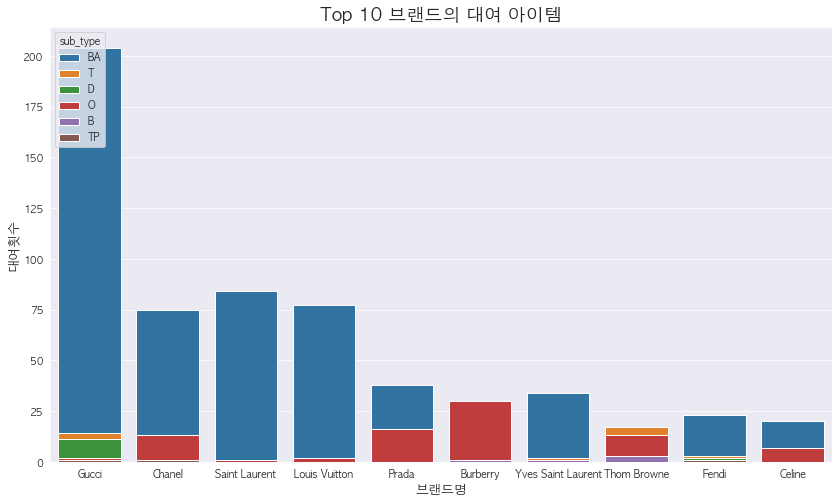

In [38]:
brand_item = data.groupby(data['brandnm'])['sub_type'].value_counts().loc[['Gucci','Chanel','Saint Laurent','Louis Vuitton','Prada',
                                                            'Burberry','Yves Saint Laurent','Thom Browne','Fendi','Celine']].to_frame()
brand_item.columns=['count']
brand_item.reset_index(inplace=True)

plt.figure(figsize=(14,8))
sns.barplot(x='brandnm', y='count', hue='sub_type', dodge=False, data=brand_item)
plt.ylabel('대여횟수', fontsize=13)
plt.xlabel('브랜드명', fontsize=13)
plt.title('Top 10 브랜드의 대여 아이템', fontsize=18);

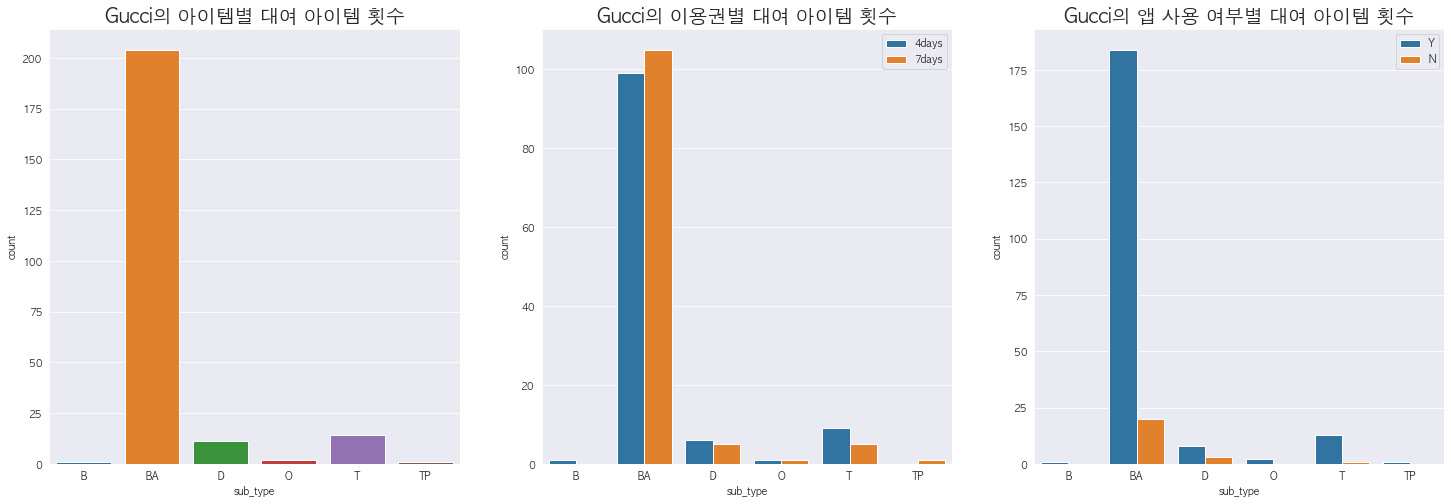

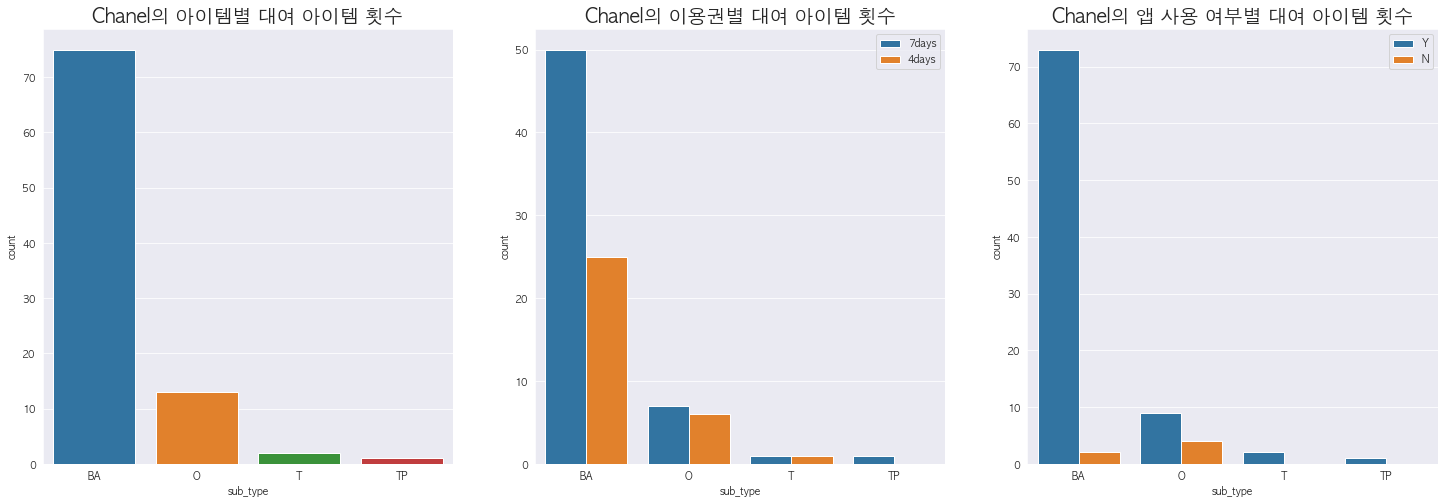

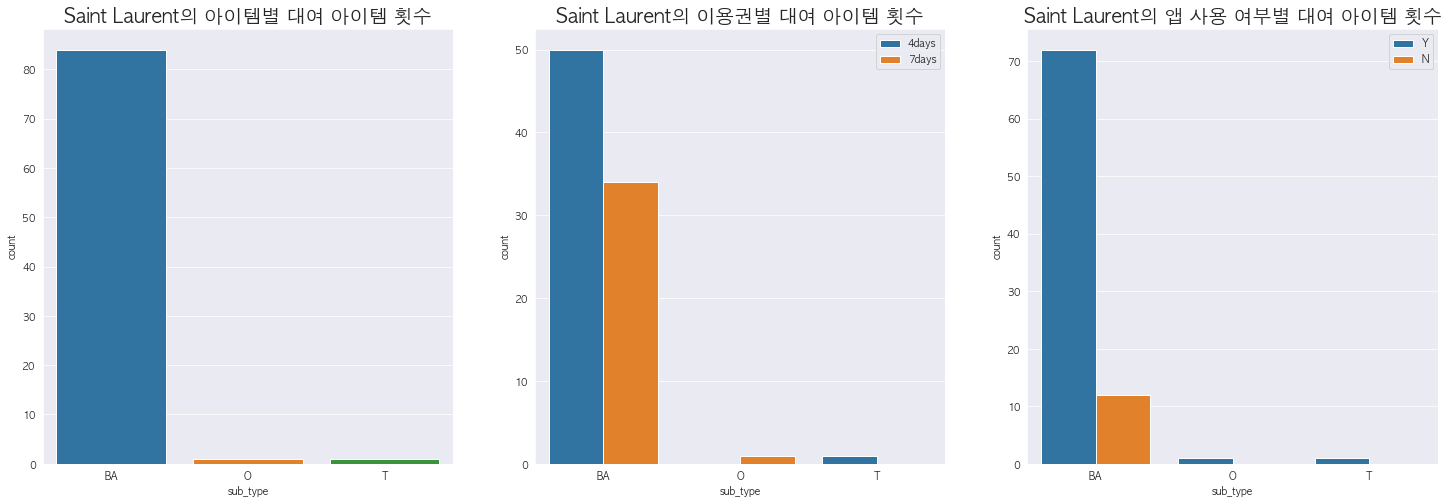

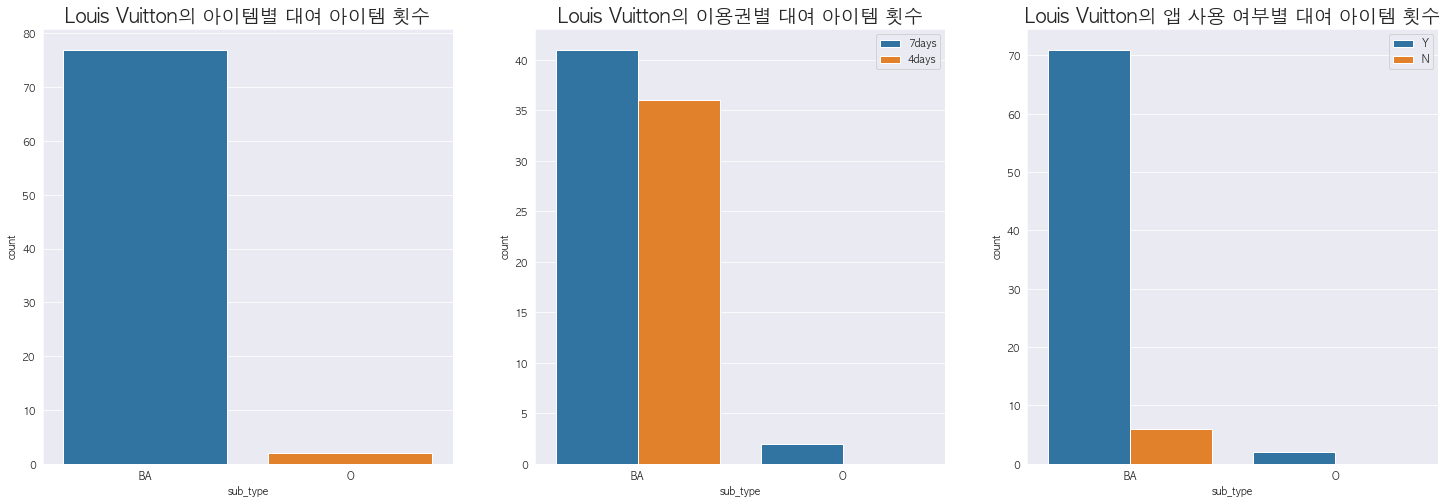

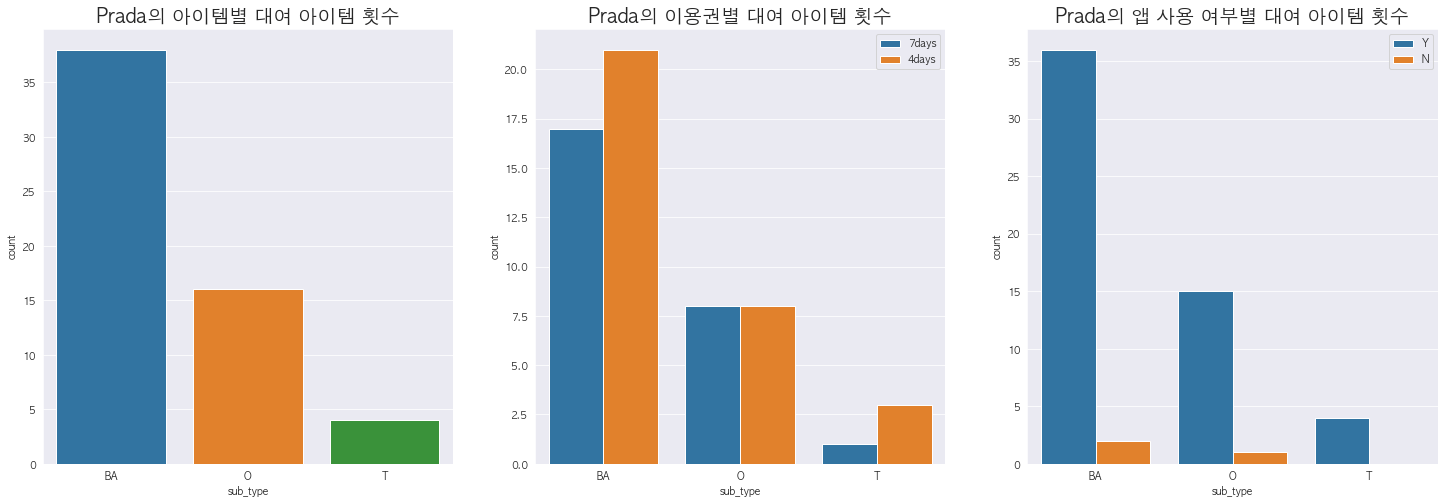

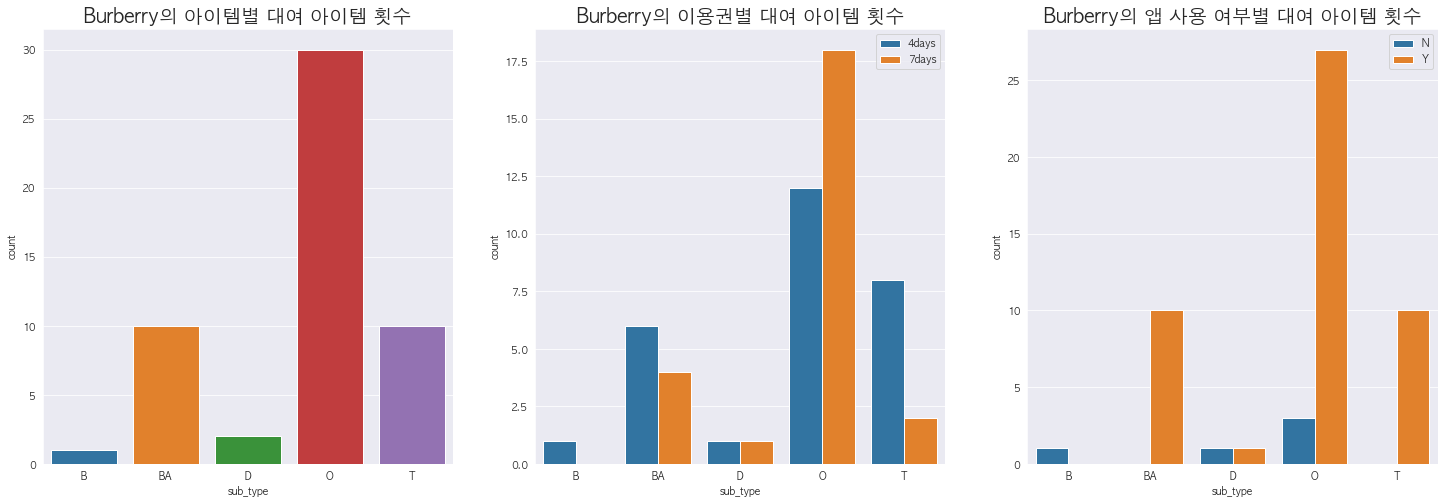

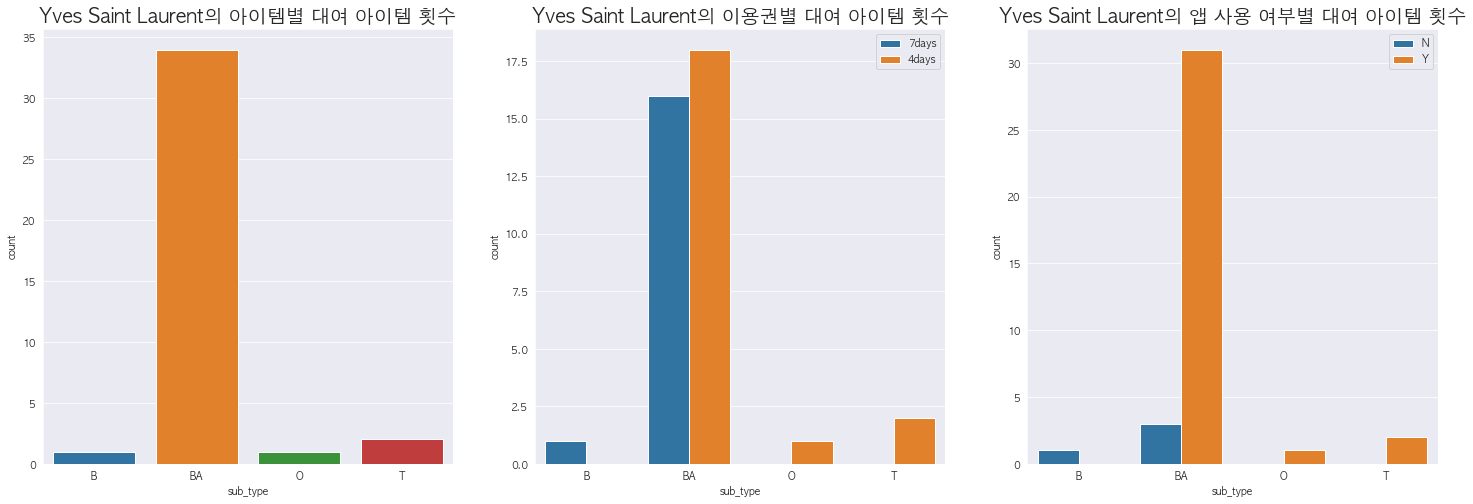

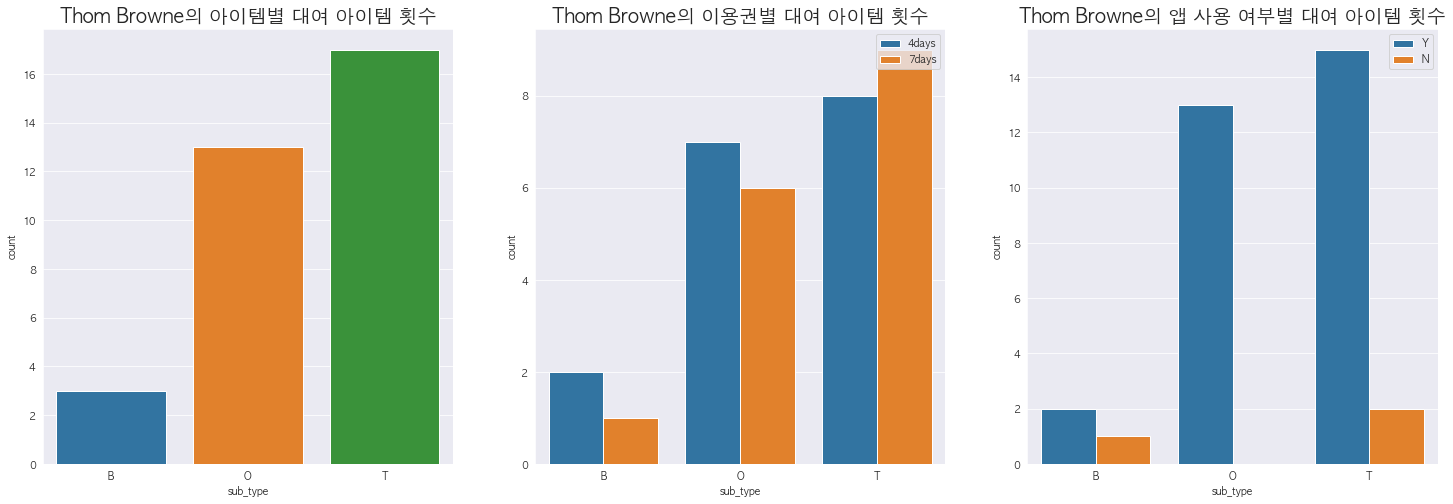

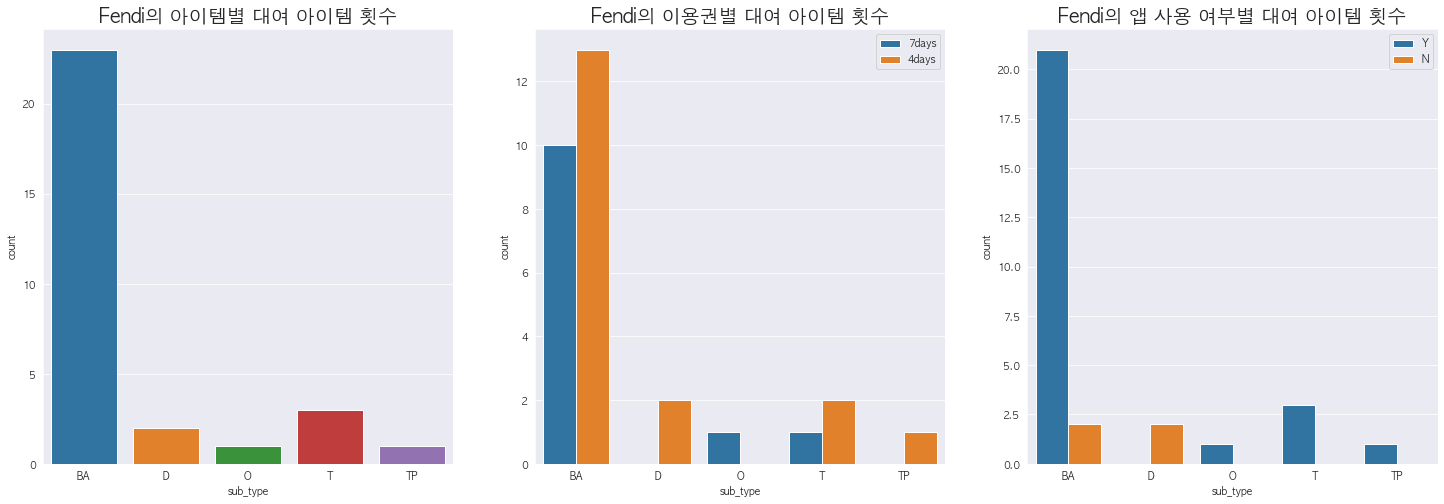

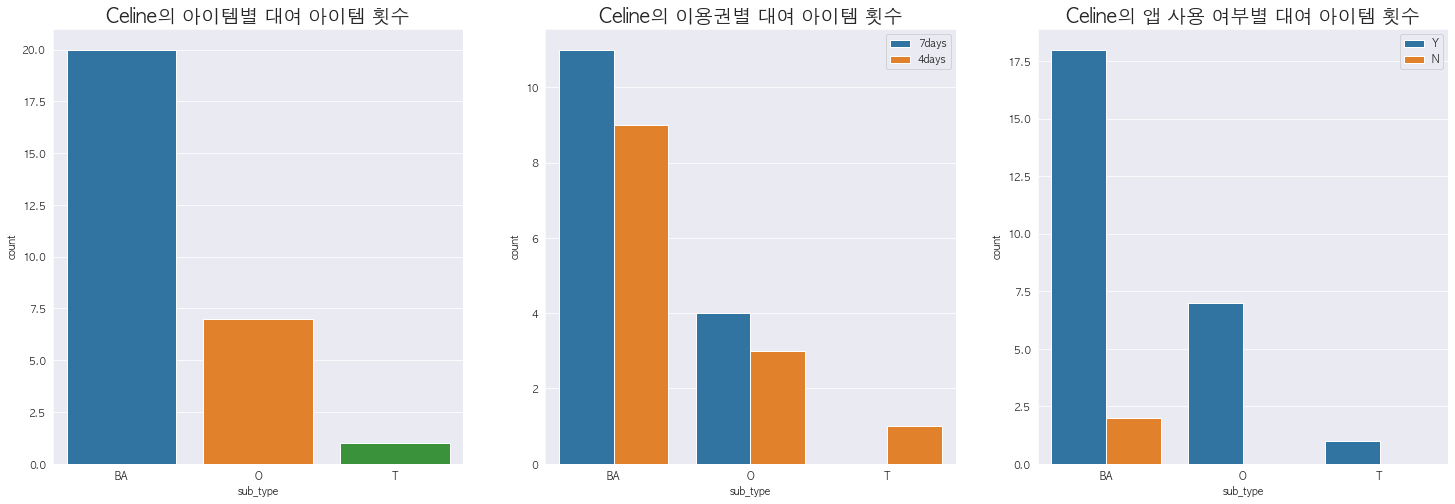

In [39]:
brand_top10 = data.groupby('brandnm').count().sort_values(by='USER',ascending=False)['USER'].head(10).index

# 그래프 그리기
for i in brand_top10:
    brand = data[data['brandnm']==i].sort_values(by='sub_type')

    f, ax = plt.subplots(1, 3, figsize = (25,8))
    sns.countplot(data=brand, x='sub_type',  ax=ax[0])
    sns.countplot(data=brand, x='sub_type', hue='p_type', ax=ax[1])
    sns.countplot(data=brand, x='sub_type', hue='app_yn', ax=ax[2])
    
    ax[0].set_title("%s의 아이템별 대여 아이템 횟수" %i, fontsize = 19)
    ax[1].set_title("%s의 이용권별 대여 아이템 횟수" %i, fontsize = 19)  
    ax[2].set_title("%s의 앱 사용 여부별 대여 아이템 횟수" %i, fontsize = 19)  
    
    ax[1].legend(loc='upper right')
    ax[2].legend(loc='upper right')

    plt.show()

### 아이템 분석 (4) : 아이템별  top 10 브랜드 

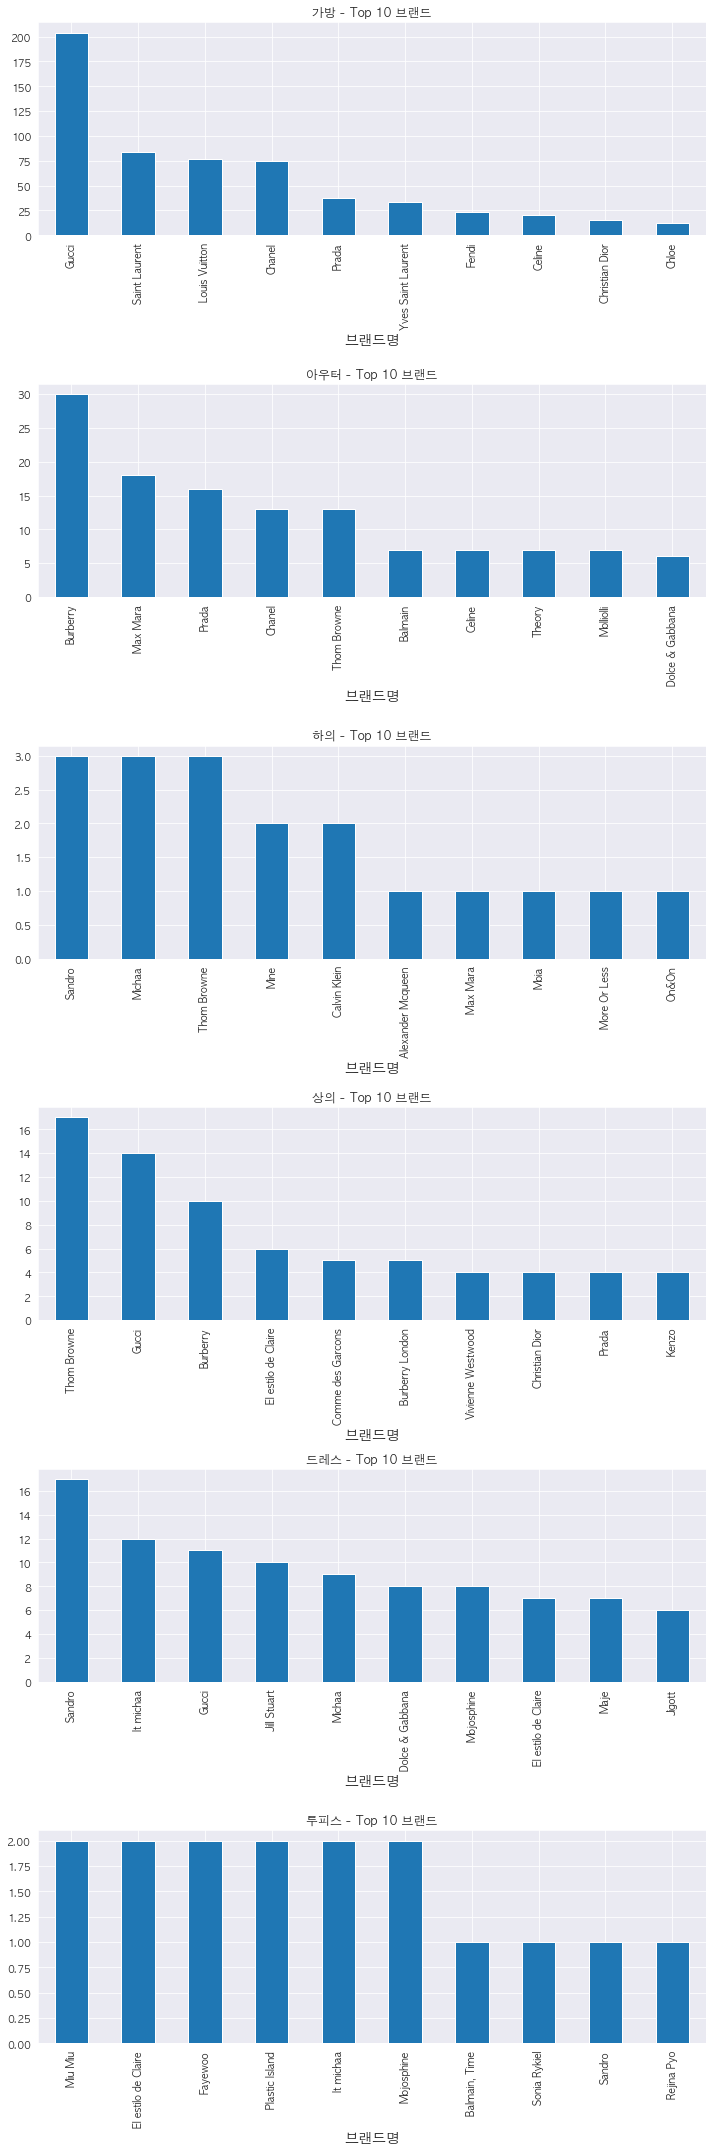

In [40]:
fig, axes = plt.subplots(6,1, figsize=(10,30))
for idx, i in enumerate(data['타입'].unique()) :
    data[data['타입']==i].groupby('brandnm').count().\
    sort_values(by='USER',ascending=False)['USER'].head(10).plot(kind='bar',\
                                                                 title= f'{i} - Top 10 브랜드', ax=axes[idx])
    axes[idx].set_xlabel('브랜드명',fontsize=14)
    plt.tight_layout() 
    


### 아이템 분석 (5) : 아이템별 색상 선호도 

In [41]:
data['component'] = data['goodsnm'].str.split()

data['color'] = 'none'

def color_ext(color):
    for i in range(len(data)):
        if (color in data['component'][i]): 
            data['color'].iloc[i]=color
            
color_list = ['beige','black','blue','pink','navy','ivory',
             'white','brown','cream','purple','deeppink',
             'nude','burgundy','grey','red',
            'skyblue', 'gold','mint','green','yellow',
             'collar','charcoal',' khaki','orange','lavender','mustard',
             'wine','salmon','rainbow','bluegreen','black&beige',
             'olive']

for i in color_list:
    color_ext(i)

In [42]:
# 중복 색 처리
for i in range(len(data)):
    if ('gray' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('gray_1' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('black1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('black_1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('Black' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    
color = data.groupby('color').count()['USER'].sort_values(ascending=False)[:20].reset_index()

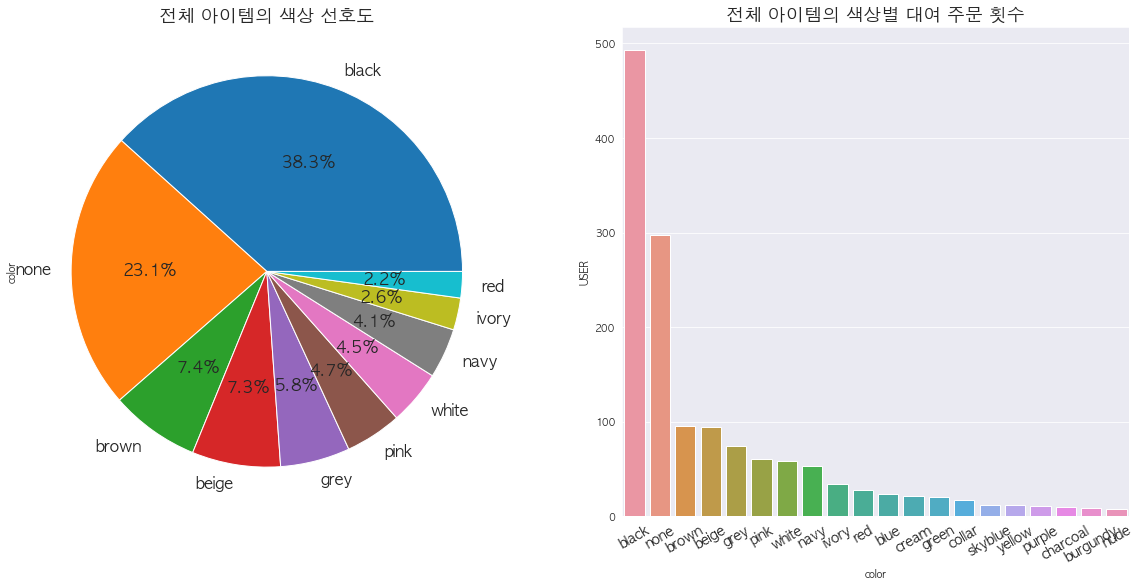

In [43]:
# 전체 아이템에 대한 색상 선호도
f, ax = plt.subplots(1,2, figsize = (20,9))

data['color'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False,  textprops={'fontsize': 16}, ax=ax[0])
sns.barplot(data=color, x='color', y='USER', ax=ax[1])

ax[0].set_title("전체 아이템의 색상 선호도", fontsize = 18)
ax[1].set_title("전체 아이템의 색상별 대여 주문 횟수", fontsize = 18)  

plt.xticks(rotation=30, size=14)
plt.show()

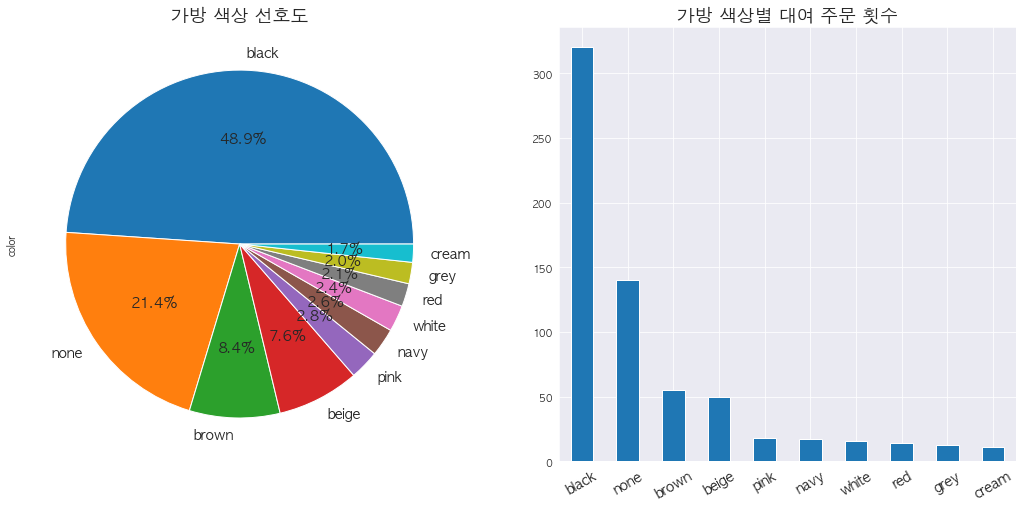

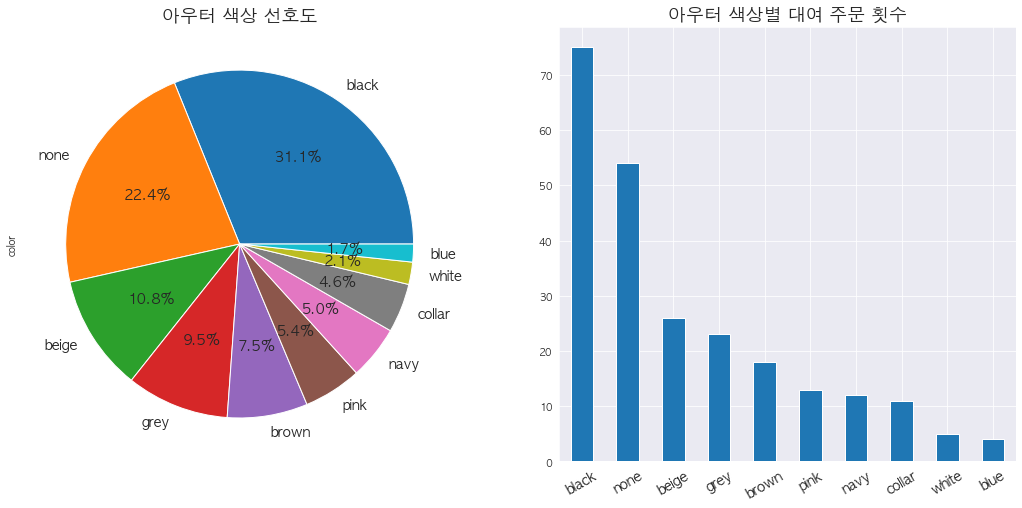

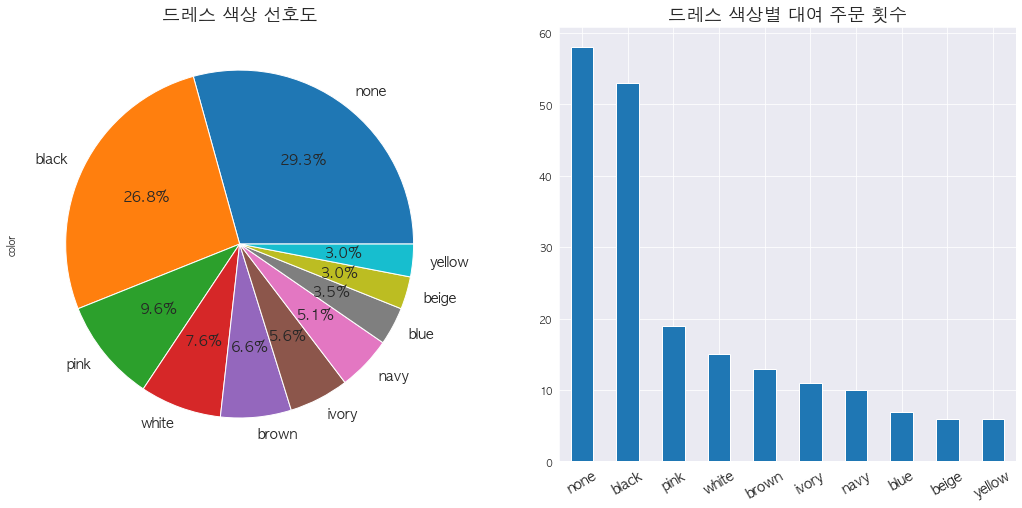

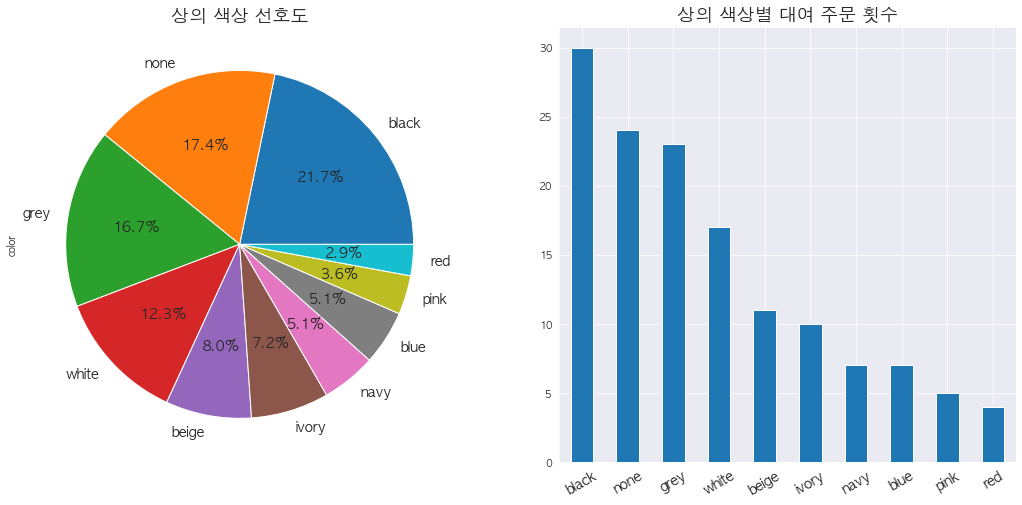

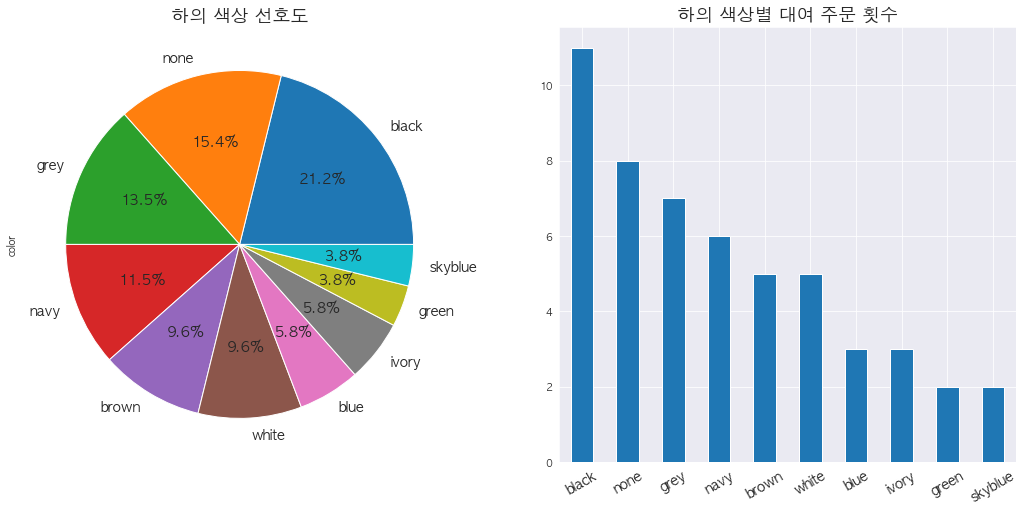

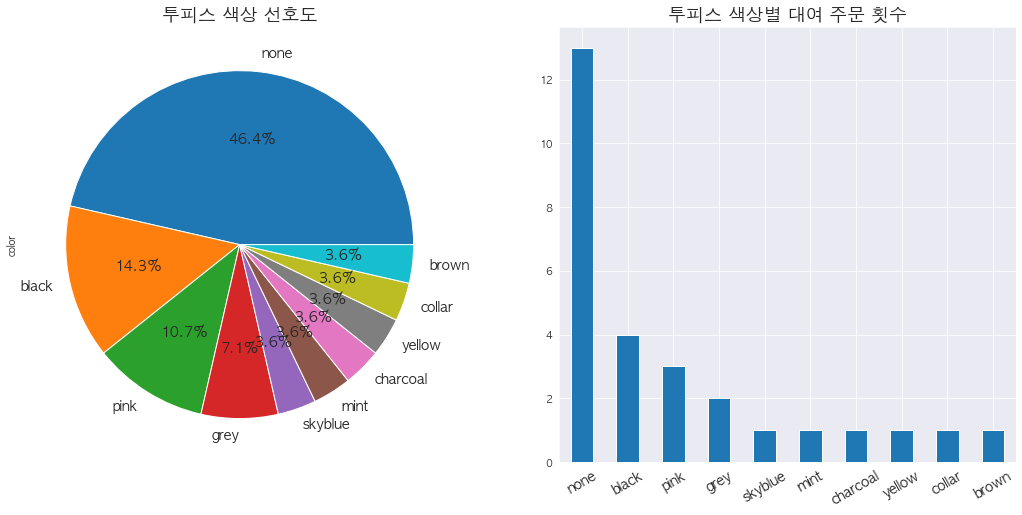

In [44]:
# 아이템 카테고리별 색상 선호도
list = data['타입'].value_counts().index

for i in list:
    f, ax = plt.subplots(1, 2, figsize = (18,8))

    data[data['타입']==i]['color'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False,  textprops={'fontsize': 14}, ax=ax[0])
    data[data['타입']==i]['color'].value_counts()[:10].plot(kind='bar', ax=ax[1])

    ax[0].set_title("%s 색상 선호도"%i, fontsize = 18)
    ax[1].set_title("%s 색상별 대여 주문 횟수"%i, fontsize = 18)  
    
    plt.xticks(rotation=30, size=14)
    plt.show()

### 아이템 분석 (6) : 월별 색상 선호도 

In [45]:
data['colors'] = np.nan
colors = set(['Black', 'ash', 'black', 'black1', 'black_1', 'beige', 
          'blue', 'bluegreen', 'brown', 'burgundy', 'charcoal', 
          'cream', 'gold', 'gray', 'gray_1', 'green', 'grey',
         'hotpink', 'ivory',  'khaki','lavender','mint',
         'mustard', 'navy', 'nude', 'olive', 'orange',
         'pink', 'purple', 'rainbow', 'red', 'salmon', 'skin',
         'skyblue', 'white', 'wine', 'yellow'])

for idx, s in enumerate(data['goodsnm'].str[:].map(str.split).values):
    if s[-1] in colors:
        data.iloc[idx, -1] = s[-1]
    elif s[-2] in colors:
        data.iloc[idx, -1] = s[-2]
    
def color_map(x):
    if x=='Black' or x=='black1' or x=='black_1':
        return 'black'
    if x=='gray' or x=='gray_1':
        return 'grey'
    if x=='wine':
        return 'burgundy'
    return x


data['colors'] = data['colors'].map(color_map)

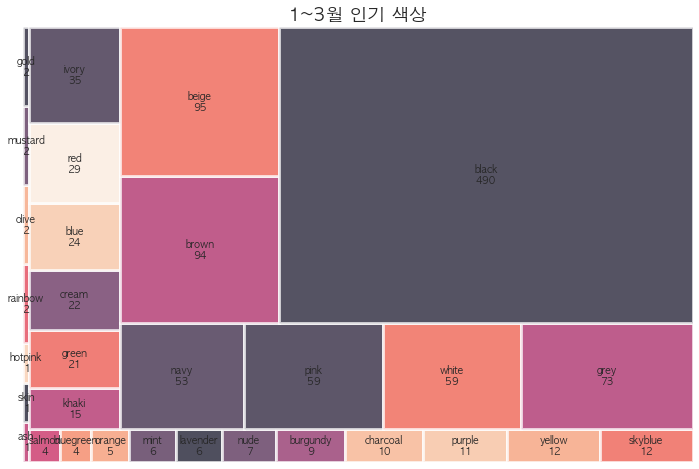

In [46]:
df_colors = data.dropna(subset=['colors'])
df_colors
df_colors_pivot = df_colors.pivot_table(index = 'colors', values = 'order_date', aggfunc = 'count').sort_values('order_date')

plt.figure(figsize=(12,8))
squarify.plot(sizes=df_colors_pivot['order_date'], label = df_colors_pivot.index, value = df_colors_pivot['order_date'], alpha=0.7,bar_kwargs=dict(linewidth=3))
plt.axis('off')
plt.title('1~3월 인기 색상', fontsize=18)
plt.show()

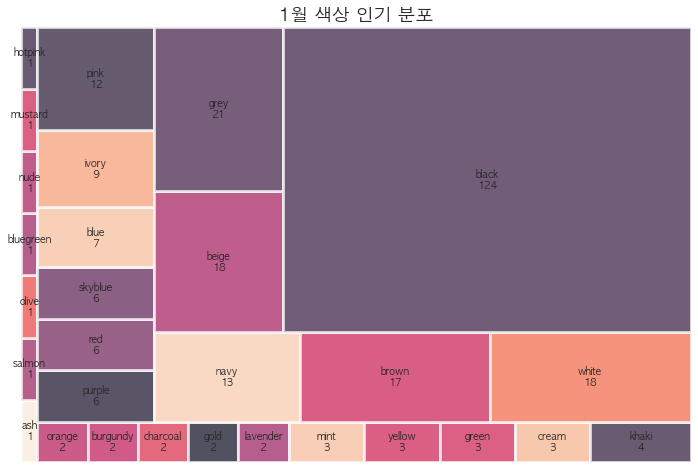

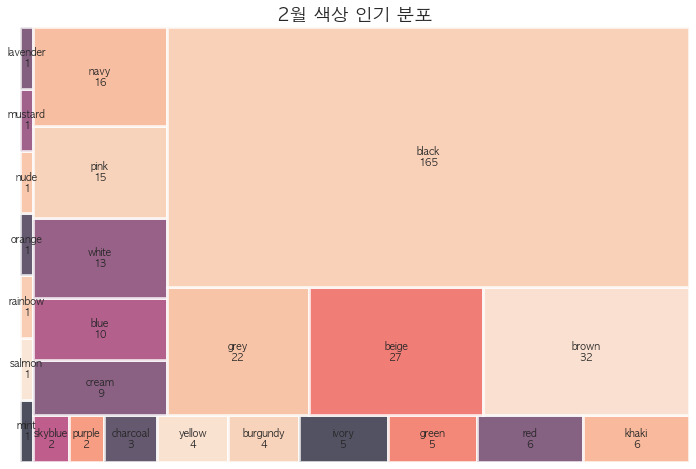

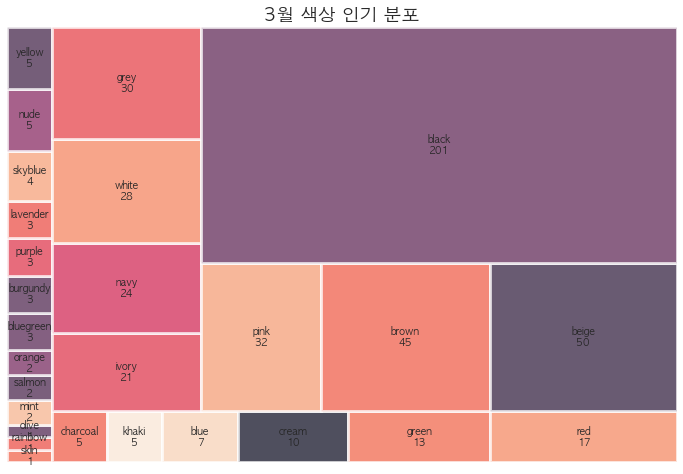

In [47]:
df_colors_month1 = df_colors[df_colors['month']==1].sort_values('day')
df_colors_month2 = df_colors[df_colors['month']==2].sort_values('day')
df_colors_month3 = df_colors[df_colors['month']==3].sort_values('day')

plt.figure(figsize=(12,8))
df_month1_color_pivot = df_colors_month1.pivot_table(index = 'colors', values = 'order_date', aggfunc = 'count').sort_values('order_date')
squarify.plot(sizes=df_month1_color_pivot['order_date'], label = df_month1_color_pivot.index, value = df_month1_color_pivot['order_date'], alpha=0.7,bar_kwargs=dict(linewidth=3))
plt.axis('off')
plt.title('1월 색상 인기 분포', fontsize=18)
plt.show()

plt.figure(figsize=(12,8))
df_month2_color_pivot = df_colors_month2.pivot_table(index = 'colors', values = 'order_date', aggfunc = 'count').sort_values('order_date')
squarify.plot(sizes=df_month2_color_pivot['order_date'], label = df_month2_color_pivot.index, value = df_month2_color_pivot['order_date'], alpha=0.7, bar_kwargs=dict(linewidth=3))
plt.axis('off')
plt.title('2월 색상 인기 분포', fontsize=18)
plt.show()

plt.figure(figsize=(12,8))
df_month3_color_pivot = df_colors_month3.pivot_table(index = 'colors', values = 'order_date', aggfunc = 'count').sort_values('order_date')
squarify.plot(sizes=df_month3_color_pivot['order_date'], label = df_month3_color_pivot.index, value = df_month3_color_pivot['order_date'], alpha=0.7, bar_kwargs=dict(linewidth=3))
plt.axis('off')
plt.title('3월 색상 인기 분포', fontsize=18)
plt.show()

### 아이템 분석 (7) : 상세 카테고리별 선호도  

In [48]:
data['item'] = 'none'

def item_exit(item):
    for i in range(len(data)):
        if (item in data['component'][i]): 
            data['item'].iloc[i]=item
            
item_list = ['shoulder','jacket','skirt','top','zipup-jumper','coat',
             'fur-outer','cross','cardigan','padding','small',
             'hobo','dress','sweater','bucket',
            'sweat-shirts', 'jumper','turtle','body','lady',
             'clutch','mini',' shirt-dress','t-shirts','sleeveless','slacks',
             'blazer','medium', 'blouse', 'tote', 'belt', 'monogramtote',
            'hoodie', 'doublebreasted-jacket', 'duffle-coat', 'padding-outer',
            'crossbody', 'jump-suit', 'shirt', 'satchel', 'trench-coat', 'logo',
            'doublebreasted-coat', 'vest', 'shirts', 'way', 'chain',
            'singlebreated-jacket', 'box', 'dionysus', 'monogram', 'saffiano',
            'regular', 'moon', 'handle', '2jours', 'chino-pants', 'city',
            'tee', 'crossbody', 'satchel']

for i in item_list:
    item_exit(i)

In [49]:
# 중복 처리
for i in range(len(data)):
    if ('shoulder' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('clutch' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('mini' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('logo' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('tote' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('cross' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('chain' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('body' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    
item = data.groupby('item').count()['USER'].sort_values(ascending=False)[:20].reset_index()

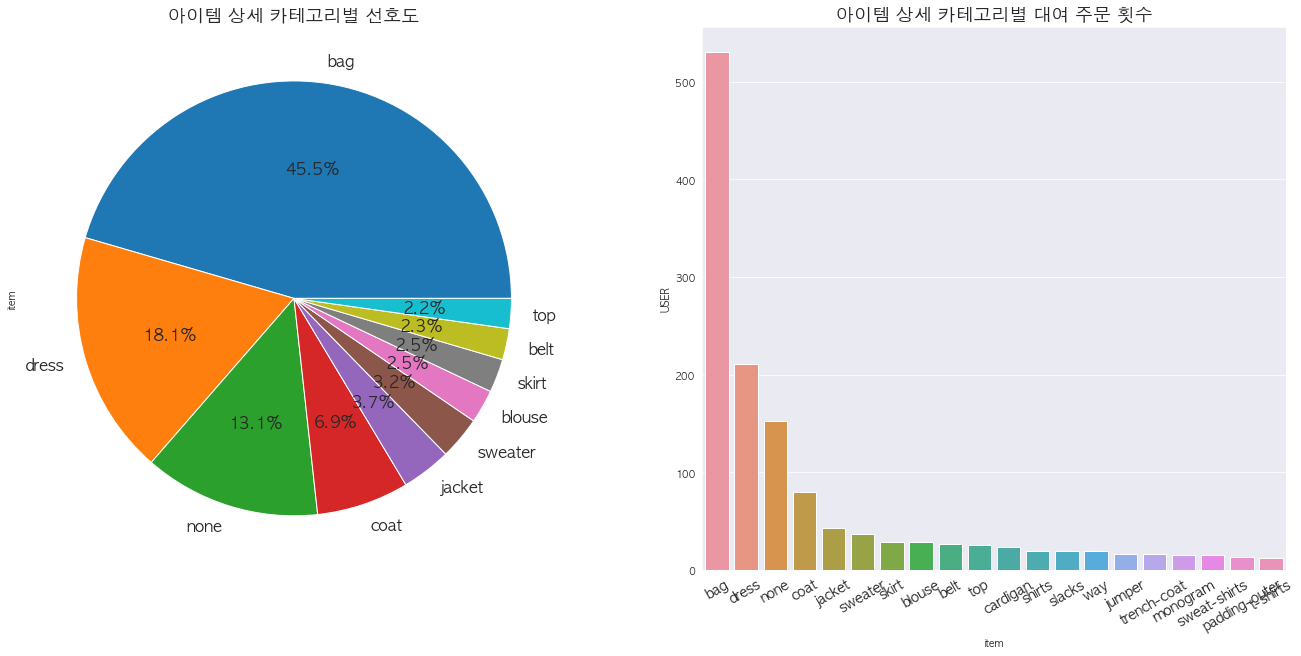

In [50]:
# 전체 아이템에 대한 제품 선호도
f, ax = plt.subplots(1,2, figsize = (23,10))

data['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False,  textprops={'fontsize': 16}, ax=ax[0])
sns.barplot(data=item, x='item', y='USER', ax=ax[1])

ax[0].set_title("아이템 상세 카테고리별 선호도", fontsize = 18)
ax[1].set_title("아이템 상세 카테고리별 대여 주문 횟수", fontsize = 18)  

plt.xticks(rotation=30, size=14)
plt.show()

In [51]:
# BAG의 세부 제품 선호도 
bag = data.query('sub_type=="BA"').reset_index()
bag['item'] = 'none'

def item_exit(item):
    for i in range(len(bag)):
        if (item in bag['component'][i]): 
            bag['item'].iloc[i]=item
            
bag_list = ['tote','shoulder','cross','clutch','backpack', 'Backpack'
            'belt','bucket','lady','luggage', 'Luggage','emily','hobo', 'small',
           'way','medium', 'drew', 'backpack', 'logo', 'mini', 'dionysus',
           'monogramotote', 'bucket', 'patent', 'satchel', 'lux', 'vitello',
           'lily', 'flab', 'lettering', 'city', 'candy', 'topaz', 'muse',
           'dotcom', 'caviar', 'bobby', 'monogram', 'classic', 'escale',
           'pionniere', 'vanity', 'regular', 'moon', 'discover', 'serpenti',
           'antigona', 'handle', 'vertical', 'boston', 'trio', 'crossbody']
    
for i in bag_list:
    item_exit(i)

# 중복처리    
for i in range(len(bag)):
    if ('crossbody' in bag['component'][i]):
       bag['item'].iloc[i] = 'cross'
    if ('luggage' in bag['component'][i]):
       bag['item'].iloc[i] = 'Luggage'
    if ('backpack' in bag['component'][i]):
       bag['item'].iloc[i] = 'Backpack'

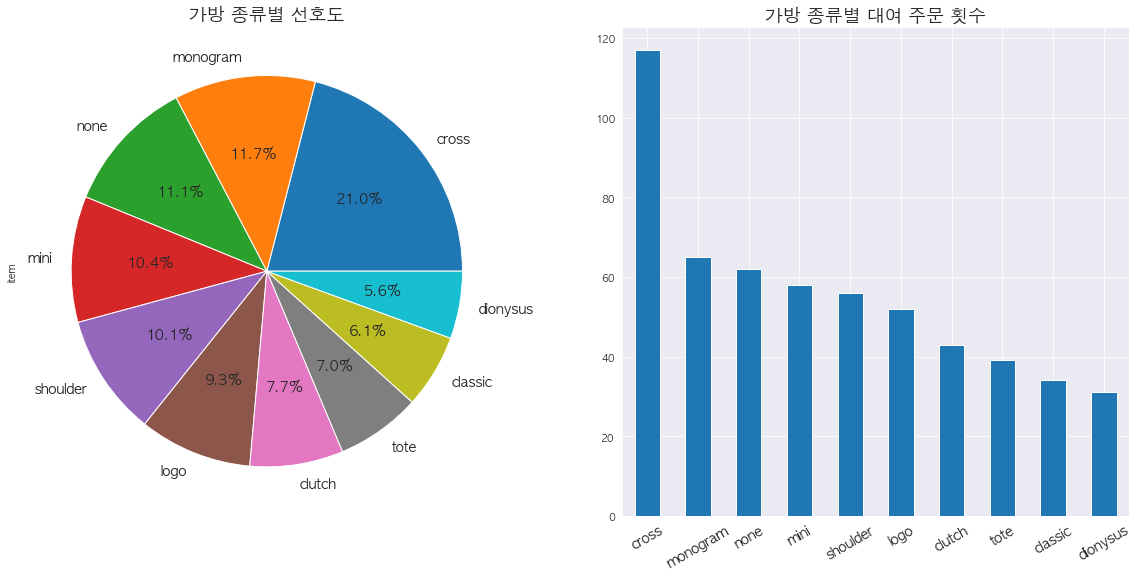

In [52]:
f, ax = plt.subplots(1,2, figsize = (20,9))

bag['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False,  textprops={'fontsize': 14}, ax=ax[0])
bag['item'].value_counts()[:10].plot(kind='bar', ax=ax[1])

ax[0].set_title("가방 종류별 선호도", fontsize = 18)
ax[1].set_title("가방 종류별 대여 주문 횟수", fontsize = 18)  

plt.xticks(size=14, rotation=30)
plt.show()

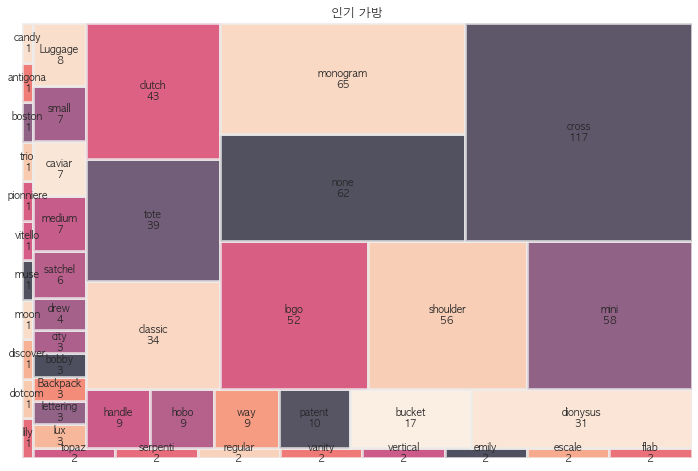

In [53]:
plt.figure(figsize=(12,8))
bag_pivot = bag.pivot_table(index = 'item', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=bag_pivot['USER'], label = bag_pivot.index, value = bag_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 가방')
plt.show()

In [54]:
# OUTER의 세부 제품 선호도 
outer = data.query('sub_type=="O"').reset_index()

for i in range(len(outer)):
    outer['component'].iloc[i] = re.split(r'-| ', outer['goodsnm'][i])
    
outer['item'] = 0

def item_exit(item):
    for i in range(len(outer)):
        if (item in outer['component'][i]): 
            outer['item'].iloc[i]=item
            
outer_list = ['jacket','coat','fur','cardigan','padding','zip-up','cape',
              'trench-coat','blazer','jumper', 'shirts', 'blouson', 'hood']
    
for i in outer_list:
    item_exit(i)
    
# 중복처리    
for i in range(len(outer)):
    if ('zipup-jumper' in outer['component'][i]):
       outer['item'].iloc[i] = 'zip-up'
    if ('wrap-coat' in outer['component'][i]):
       outer['item'].iloc[i] = 'coat'
    if ('fullzip-jacket' in outer['component'][i]):
       outer['item'].iloc[i] = 'jacket'

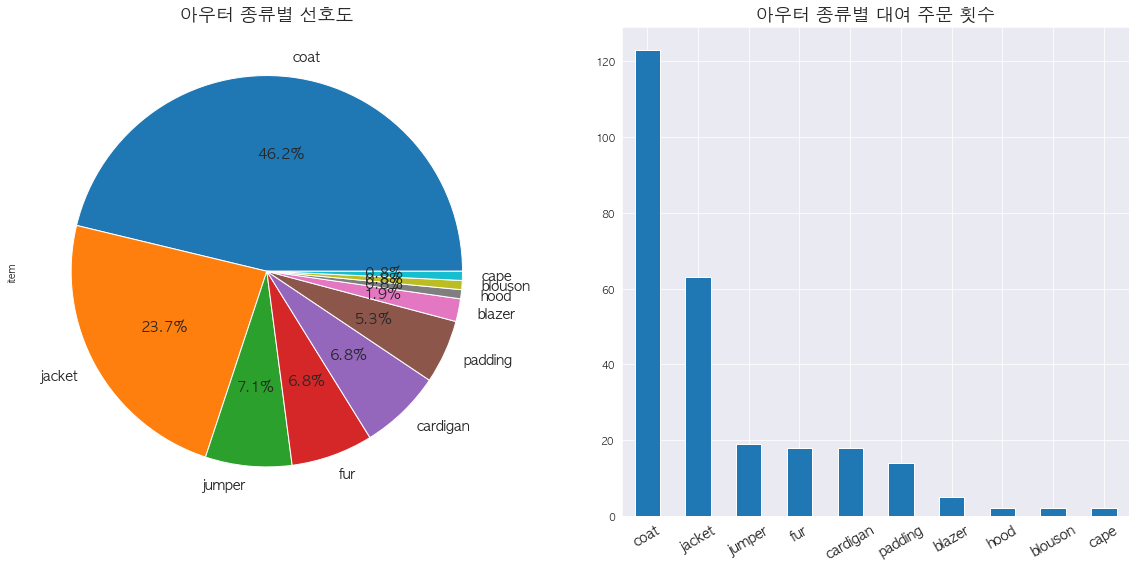

In [55]:
f, ax = plt.subplots(1,2, figsize = (20,9))

outer['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, textprops={'fontsize': 14}, ax=ax[0])
outer['item'].value_counts()[:10].plot(kind='bar', ax=ax[1])

ax[0].set_title("아우터 종류별 선호도", fontsize = 18)
ax[1].set_title("아우터 종류별 대여 주문 횟수", fontsize = 18)  

plt.xticks(size=14, rotation=30)
plt.show()

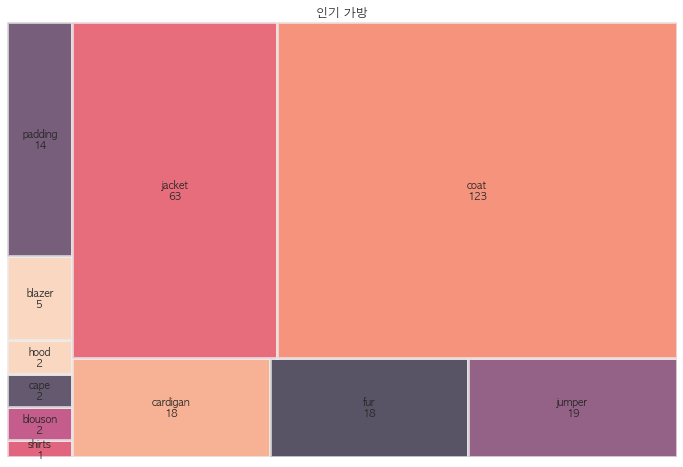

In [56]:
plt.figure(figsize=(12,8))
outer_pivot = outer.pivot_table(index = 'item', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=outer_pivot['USER'], label = outer_pivot.index, value = outer_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 가방')
plt.show()

### 아이템 분석 (7) :  아이템별 첫 대여에서 선택될 확률   
- 첫 대여 아이템이 될 확률은 가방이 가장 높고 뒤이어 아우터, 드레스, 상의, 하의, 투피스 순임.  
- 가방이 주력 상품임을 확인할 수 있음  

In [57]:
temp = pd.DataFrame(data.groupby(['USER','sub_type']).count()['goodsnm'].unstack())

print("유저가 첫 대여로 하의를 고를 확률:",temp['B'].notnull().sum()/len(temp))
print('='*80)
print("유저가 첫 대여로 가방 고를 확률:",temp['BA'].notnull().sum()/len(temp))
print('='*80)
print("유저가 첫 대여로 드레스를 고를 확률:",temp['D'].notnull().sum()/len(temp))
print('='*80)
print("유저가 첫 대여로 아우터를 고를 확률:",temp['O'].notnull().sum()/len(temp))
print('='*80)
print("유저가 첫 대여로 상의를 고를 확률:",temp['T'].notnull().sum()/len(temp))
print('='*80)
print("유저가 첫 대여로 투피스를 고를 확률:",temp['TP'].notnull().sum()/len(temp))

유저가 첫 대여로 하의를 고를 확률: 0.03565640194489465
유저가 첫 대여로 가방 고를 확률: 0.559967585089141
유저가 첫 대여로 드레스를 고를 확률: 0.17828200972447325
유저가 첫 대여로 아우터를 고를 확률: 0.20826580226904376
유저가 첫 대여로 상의를 고를 확률: 0.1085899513776337
유저가 첫 대여로 투피스를 고를 확률: 0.02188006482982172


# ✍🏻 Action Plan 

##  1️⃣ 클러스터링과 코호트 분석에 기반한 기존 고객 및 신규 고객의 구매 유지율 개선 방안 
**❖ 클러스터링 결과와 코호트 분석의 결과 종합** 
> - 클러스터링 결과 신규 유입 회원으로 구성된 군집일수록 다양한 브랜드를 렌탈하고 렌탈 횟수의 범위도 비교적 넓은 편으로 보이며 렌탈한 카테고리 종류도 고루 분포됨. 반대로 가입일이 오래된 회원으로 구성된 군집일수록 렌탈 횟수와 렌탈한 브랜드의 종류, 렌탈한 카테고리 종류가 적음.   
> - 코호트 분석 결과 2주차 구매 유지율을 사수해야 이후 구매 유지율이 안정화되는 경향을 보임. 가입 4년차 이상의 기존 고객들의 서비스 이용률이 낮은점, 시즌 특수성이 있음을 볼 수 있음.     
  
**❖ 도출 가능한 액션 플랜** 
>**√ 신규 유입 회원으로 구성된 군집 : 첫 주의 서비스 경험을 지속화 시키는게 중요**  
:: 2+1 쿠폰혜택, 더블쿠폰 혜택 등의 쿠폰 서비스, 후기 이벤트, 브랜드데이 이벤트 등을 통해 지속적으로 서비스 경험을 유지하도록 장려하여 1주차 구매 유지율을 장기적으로 끌고 가야 함.  
:: 카테고리 묶음 이벤트(상의+하의를 함께 렌탈시 2000원 할인 쿠폰 증정 등)를 통해 하나의 아이템만이 아니라 보다 다양한 아이템을 지속적으로 렌탈할 수 있게끔 장려해야 함   

> **√ 오래된 회원들로 구성된 군집 : 서비스의 재각인이 중요**  
:: push notification 등의 환기성 이벤트를 시행하여 클로젯 셰어의 서비스를 프레쉬한 이미지로재각인시킬 필요가 있음. 이들에게는 처음 서비스를 이용했을 때의 새로움을 각인시키는게 중요해보임.
  

### Kmeans 클러스터링

In [58]:
# 유저별 결제건수 컬럼
u_ndf = data['USER'].value_counts().to_frame()
u_ndf.reset_index(inplace = True)
u_ndf.columns = ['USER','count']
ndf = pd.merge(data, u_ndf, how='left', left_on='USER', right_on='USER')
ndf
# 경과일 컬럼
ndf['Elapsed_day'] = ndf['order_date']-ndf['reg_date']
for i in range(len(ndf['Elapsed_day'])):
    ndf['Elapsed_day'].iloc[i] = str(ndf['Elapsed_day'].iloc[i]).split('days')[0]

# 가입 월, 일 컬럼
ndf['reg_Month'] = [k for k in ndf['reg_date'].dt.month]
ndf['reg_Day'] = [k for k in ndf['reg_date'].dt.day]

# 주문 월, 일 컬럼
ndf['order_Month'] = [k for k in ndf['order_date'].dt.month]
ndf['order_Day'] = [k for k in ndf['order_date'].dt.day]

# 'USER' 숫자형으로 변환
for i in range(len(ndf['USER'])):
    ndf['USER'].iloc[i] = ndf['USER'].iloc[i].split('a')[1]

# 'p_type' 숫자형으로 변환
for i in range(len(ndf['p_type'])):
    ndf['p_type'].iloc[i] = ndf['p_type'].iloc[i].split('days')[0]
    
ndf = ndf.astype({'USER':int, 'p_type':int, 'Elapsed_day':int})

# 범주형 컬럼 레이블인코딩하여 숫자형으로
le = preprocessing.LabelEncoder()

ndf['brandnm'] = le.fit_transform(ndf['brandnm'])
ndf['sub_type'] = le.fit_transform(ndf['sub_type'])
ndf['app_yn'] = le.fit_transform(ndf['app_yn'])

# 불필요한 컬럼 삭제

drop_cols=[ 'order_month', 'order_day', 'order_dayofweek', 'reg_date_ym', 'reg_date_w',
       'reg_date_ymw', 'order_date_ym', 'order_date_w', 'order_date_ymw', 'month', 
           'day', '타입', 'component', 'colors', 'color', 'item', 'goodsnm', 'reg_date', 'order_date']

ndf.drop(drop_cols,1, inplace=True)

In [59]:
model = KMeans(n_clusters=4, max_iter=10000, random_state=42)
pred = model.fit_predict(ndf)

# 예측값과 데이터프레임 병합
pred = pd.DataFrame(pred)
pred.columns=['predict']
r = pd.concat([ndf,pred],axis=1)

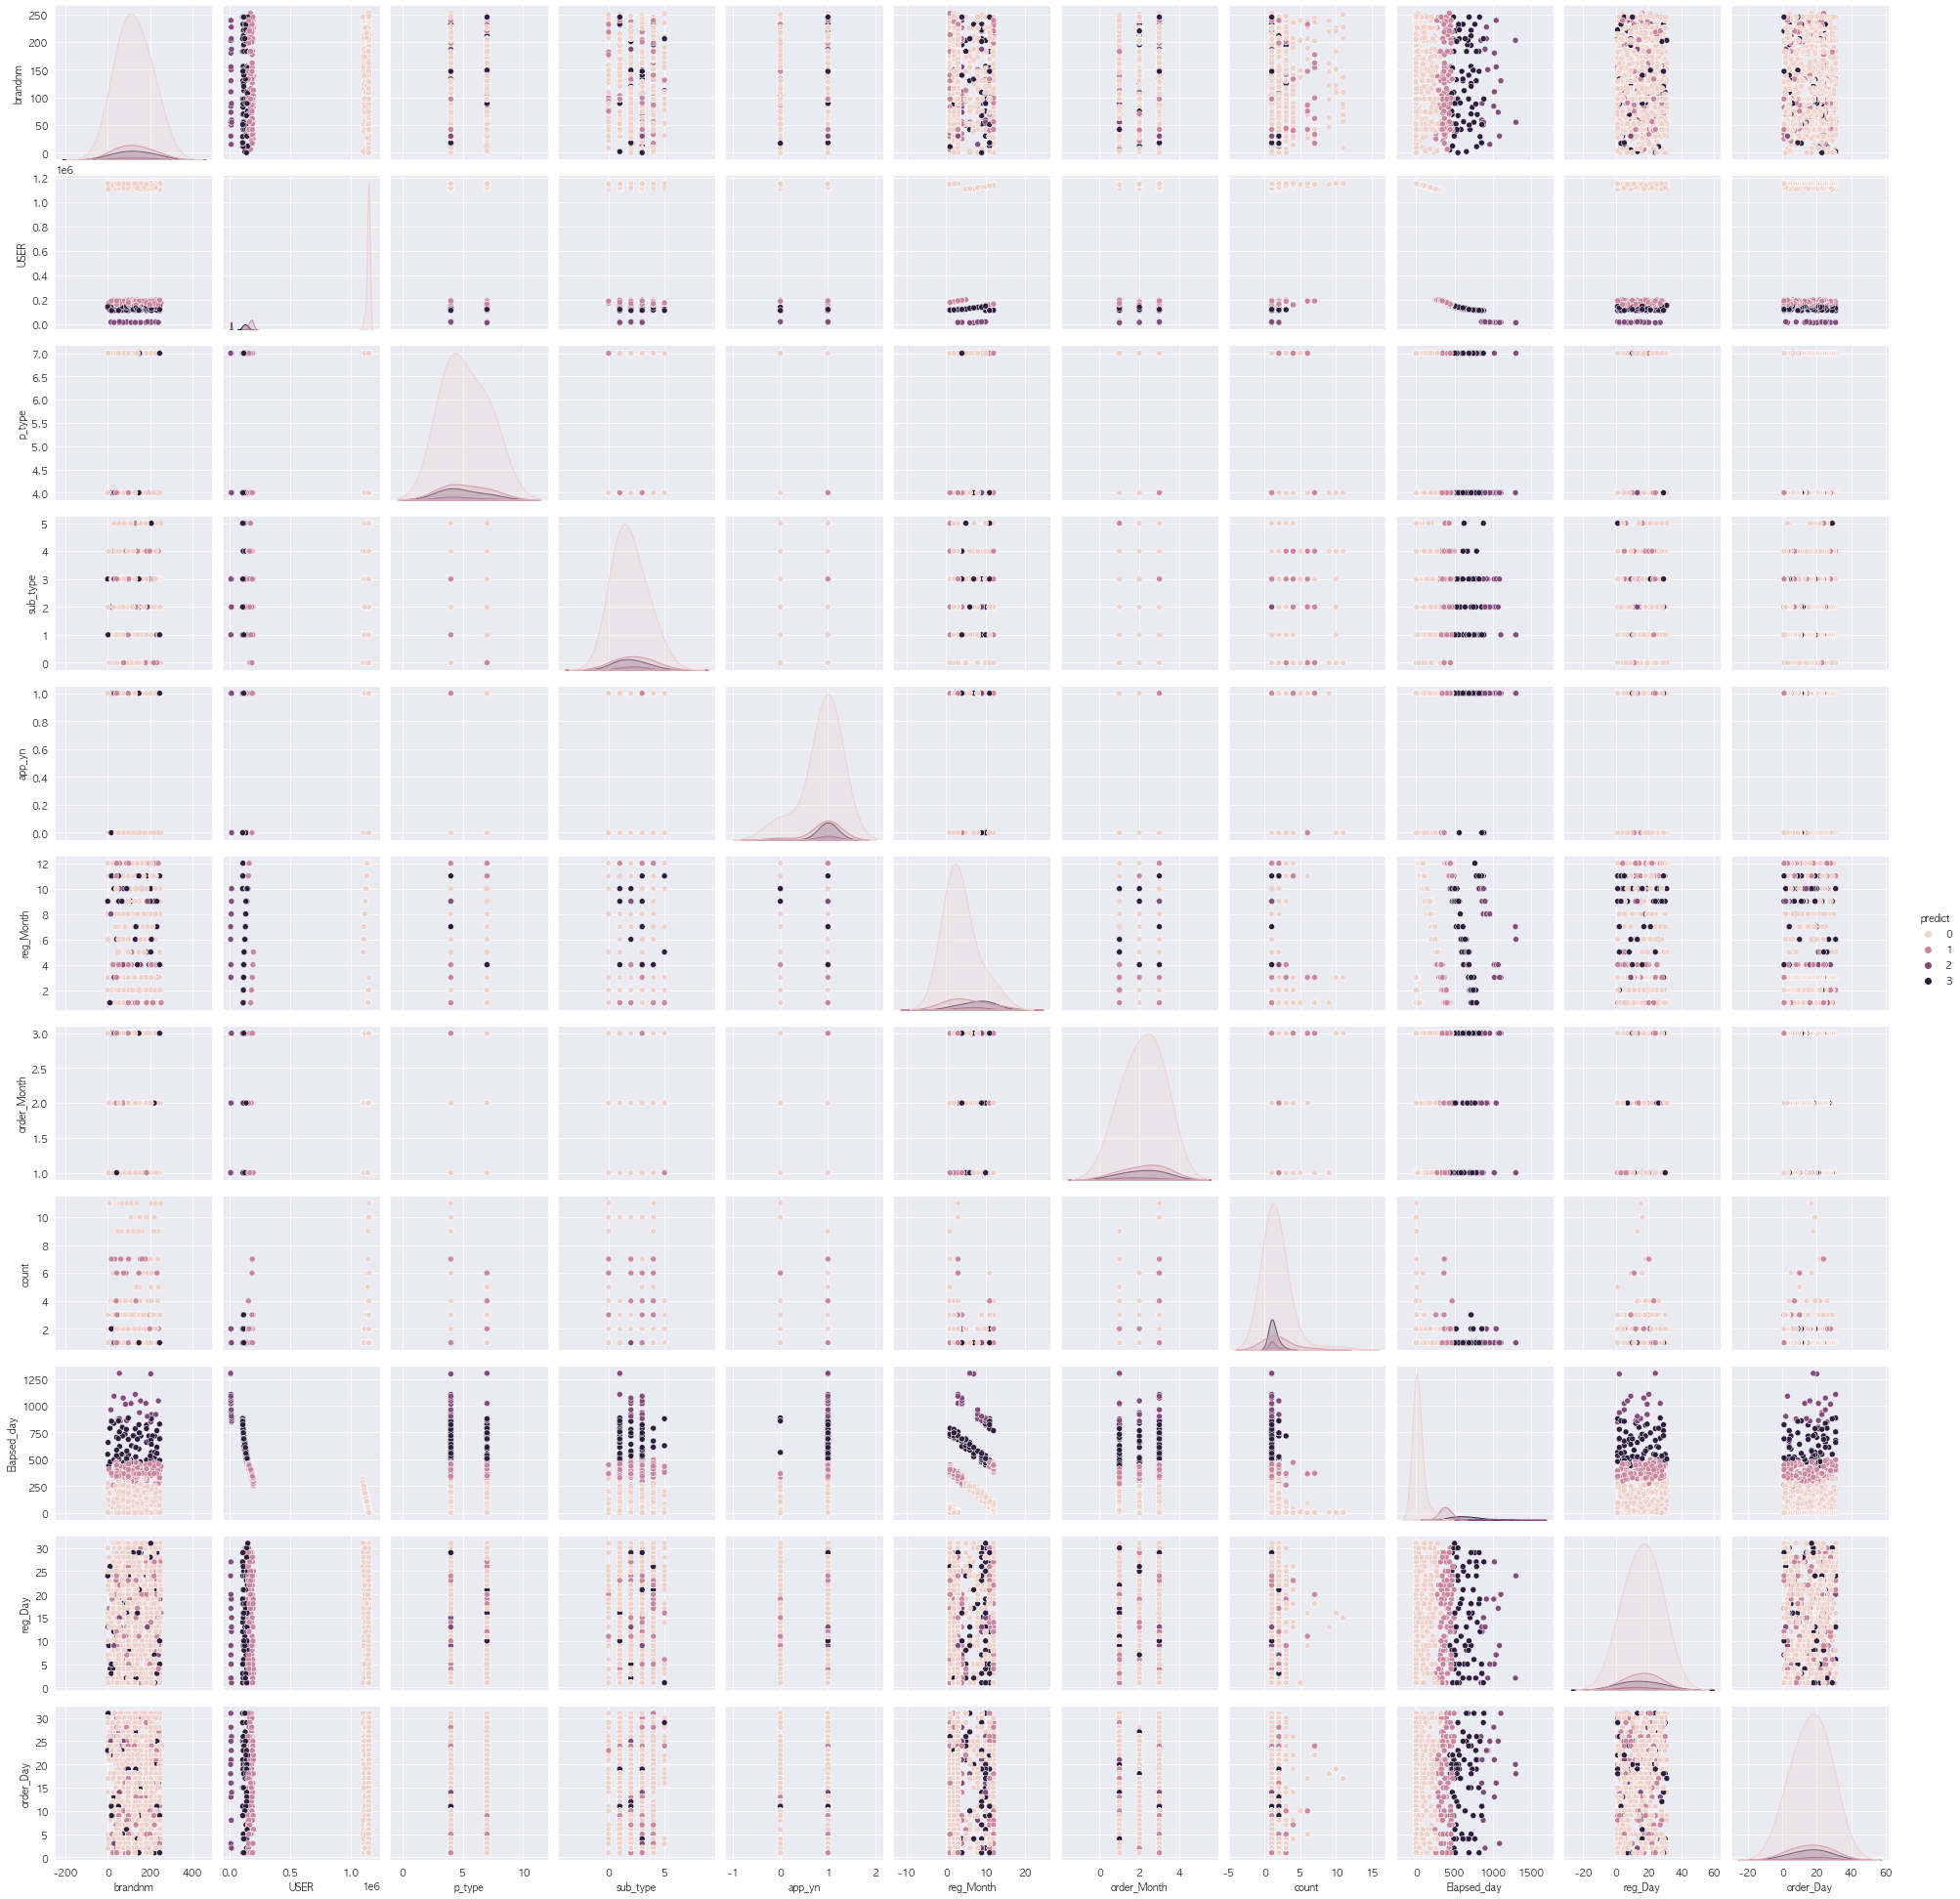

In [60]:
# 예측 데이터 시각화
sns.pairplot(r, hue='predict',diag_kws = { 'bw': 1})
plt.show()

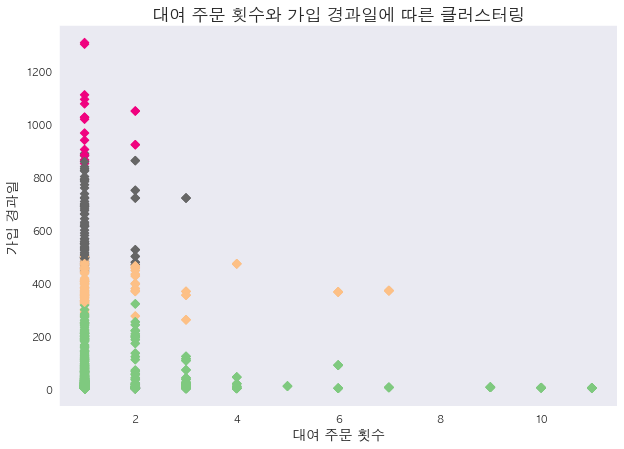

In [61]:
plt.figure(figsize=(10,7))
colors = np.random.rand(10)
plt.scatter(x=ndf['count'], y=ndf['Elapsed_day'], c=r['predict'], cmap='Accent', marker='D')
plt.title('대여 주문 횟수와 가입 경과일에 따른 클러스터링', fontsize=17)
plt.xlabel('대여 주문 횟수', fontsize=14)
plt.ylabel('가입 경과일', fontsize=14)
plt.grid(alpha=0.8, linestyle='--')

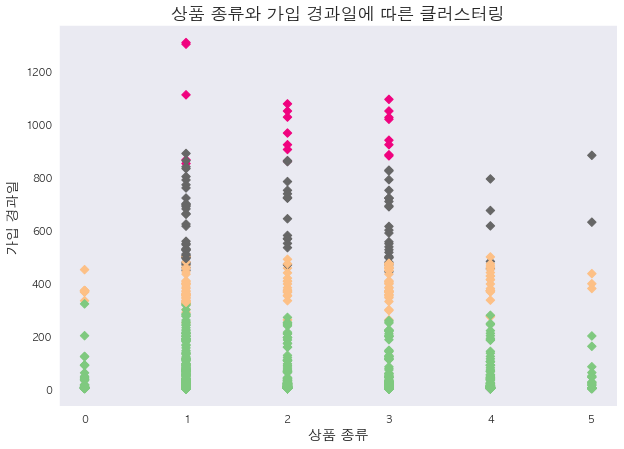

In [62]:
plt.figure(figsize=(10,7))
plt.scatter(x=ndf['sub_type'], y=ndf['Elapsed_day'], c=r['predict'], cmap='Accent', marker='D')
plt.title('상품 종류와 가입 경과일에 따른 클러스터링', fontsize=17)
plt.xlabel('상품 종류', fontsize=14)
plt.ylabel('가입 경과일', fontsize=14)
plt.grid(alpha=0.8, linestyle='--')

## 2️⃣ 렌탈 활성화를 위한 추천 시스템 : 협업 기반 필터링으로 다양한 카테고리 아이템 추천
❖ 현 추천 시스템의 한계
> √ 현재 컨텐츠 기반 추천시스템이 도입되어 활용 중이긴 하나 **아이템별 추천 시스템의 편차가 심해보임**(어떤 아이템에는 1개만 추천해주는 반면 어떤 아이템은 5개 이상을 추천)  
> √ 또한 선택한 아이템과 유사한 아이템만 추천해 줄 뿐 어울리는 아이템을 추천해주지 않음 **다양한 상품을 추천해 주지 않음**
    
❖ 도출 가능한 액션 플랜  
> √ 한계를 보완하기 위해 컨텐츠 기반에서 **협업 필터링 기반의 추천 시스템으로 확대**할 것을 제안함.  
√ 가방이 주력 상품이긴 하지만 **가방만으로 사업을 끌고 가기보다는 의류 아이템도 함께 성장해야 사업의 지속가능성이 보장될 것임.** 따라서 **최근접 이웃 협업 필터링 기반이나 잠재 요인 협업 필터링 추천 시스템을 확대 도입하여 동일 카테고리의 아이템 뿐만 아니라 유저가 선택한 아이템과 잘 어울리는 다른 카테고리의 아이템을 추천해주는 시스템이 필요할 것으로 사료됨**  

### 컨텐츠 기반 추천 시스템 예시

In [63]:
# sub_type 별로 분리
data_ba = data[data['sub_type']=='BA']
data_o = data[data['sub_type']=='O']
data_d = data[data['sub_type']=='D']
data_t = data[data['sub_type']=='T']
data_b = data[data['sub_type']=='B']
data_tp = data[data['sub_type']=='TP']

#goodsnm 벡터화
tfidf = TfidfVectorizer()

tfidf_matrix_bottom = tfidf.fit_transform(data_b['goodsnm'])
cosine_matrix_bottom = cosine_similarity(tfidf_matrix_bottom, tfidf_matrix_bottom)

# bottom dataframe을 skirt와 pants로 분리
data_skirt = data_b.loc[data_b['goodsnm'].str.contains('skirt' or 'skirts')]
data_pants = data_b.loc[data_b['goodsnm'].str.contains('skirt' or 'skirts')==False]

# sub_type 별 cosine 유사도 함수화
def Cosine_Subtype(df_x, idx): #df_x = sub_type별 데이터프레임, idx = goodsnm 품목 명
    tfidf_matrix_sub = tfidf.fit_transform(df_x['goodsnm'])
    cosine_matrix_sub = cosine_similarity(tfidf_matrix_sub,tfidf_matrix_sub)
    np.round(cosine_matrix_sub,4)
    #딕셔너리 생성
    goods_id = {}
    for i, c in enumerate(df_x['goodsnm']): goods_id[i] = c
    #아이디 별 굿즈 이름
    id2goods = {}
    for o, p in goods_id.items(): id2goods[p] =o
    
    idx_ = id2goods[idx]
    sim_scores = [(y,z) for y, z in enumerate(cosine_matrix_sub[idx_]) if y !=idx_] 
    sim_scores = sorted(sim_scores, key =lambda x: x[1], reverse = True)
    sim_scores = [(goods_id[w], score) for w , score in sim_scores[0:15]]
    
   #중복 제거 
    my_sim_scores = []
    for v in sim_scores:
        if v not in my_sim_scores:
            my_sim_scores.append(v)
    return my_sim_scores[0:5]

In [64]:
# pants
item_nm='pocket basic pattern slacks black'
print(f'{item_nm}과 비슷한 상품')
print('='*80)
Cosine_Subtype(data_b, item_nm)

pocket basic pattern slacks black과 비슷한 상품


[('pocket basic pattern slacks black', 1.0000000000000002),
 ('pocket stripe pattern slacks black', 0.6538873230543492),
 ('pocket basic pattern slacks navy', 0.6225073330421497),
 ('ribbon basic pattern slacks black', 0.6214580547261949),
 ('buckle basic pattern slacks black', 0.5905248692538959)]

In [65]:
item_nm='dionysus cross bag'
print(f'{item_nm}과 비슷한 상품')
print('='*80)
Cosine_Subtype(data_ba, item_nm)

dionysus cross bag과 비슷한 상품


[('dionysus cross bag', 1.0),
 ('dionysus cross bag black', 0.9378765143550344),
 ('dionysus bag', 0.8678766041315753),
 ('dionysus cross bag beige', 0.7982556599047357)]

## 3️⃣ 수요 쏠림 현상을 완화하기 위한 인기 브랜드 입점 장려   

In [66]:
df_add= pd.read_csv('closetDB.csv')
df_add.drop(df_add.columns[0:2], axis=1, inplace=True)
df_add.head()

goodsnm        brandnm  Record Count   상태  \
0  chevron quilted cross bag black  Saint Laurent            23  4.0   
1             classic clutch black         Chanel            12  4.0   
2          boy chanel clutch black         Chanel            11  4.0   
3   padlock GG canvas shoulder bag          Gucci             9  3.0   
4      mini sunset chain bag black  Saint Laurent             8  3.0   

                 태그 사이즈      소재  \
0  #오피스 #위켄드 #포멀이벤트   M  송아지 가죽   
1            #포멀이벤트   M     양가죽   
2       #위켄드 #포멀이벤트   M    염소가죽   
3         #오피스 #위켄드   S     패브릭   
4              #오피스   M  송아지 가죽   

                                              이미지url          가방종류  
0  https://upload.closetshare.com/StaticContent/s...     cross bag  
1  https://upload.closetshare.com/StaticContent/s...        clutch  
2  https://upload.closetshare.com/StaticContent/s...        clutch  
3  https://upload.closetshare.com/StaticContent/s...  shoulder bag  
4  https://upload.closetshare.com/StaticContent/s...     chain bag

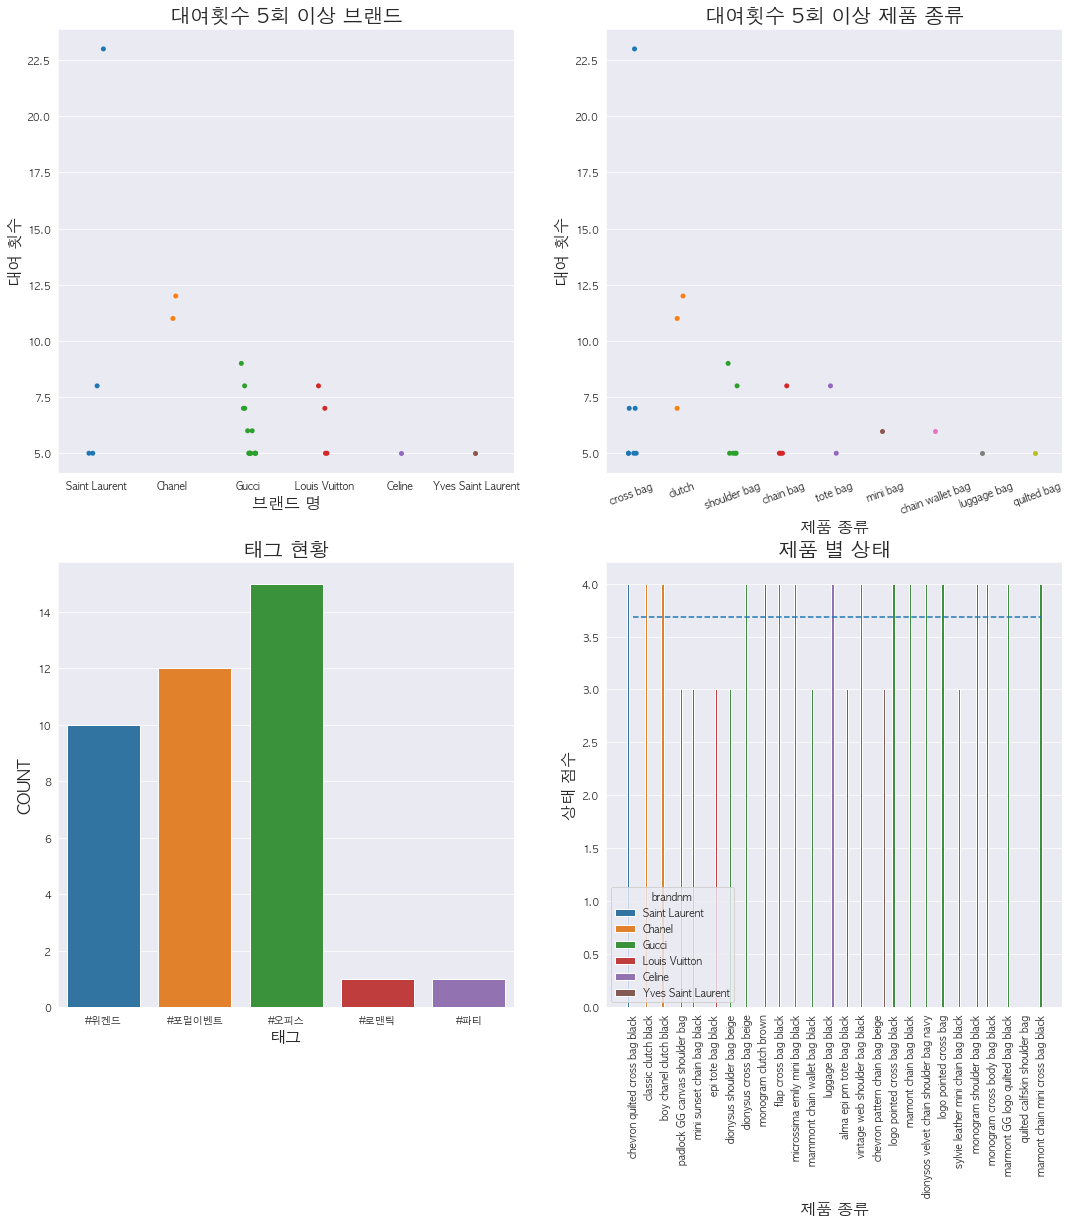

In [67]:
fig = plt.figure(figsize=(18,18))
gs = GridSpec(2,2)

sns.stripplot(x=df_add['brandnm'], y=df_add['Record Count'], ax=fig.add_subplot(gs[0,0]),)
plt.xlabel('브랜드 명', fontsize=16)
plt.ylabel('대여 횟수', fontsize=16)
plt.title('대여횟수 5회 이상 브랜드', fontsize=20)

sns.stripplot(x=df_add['가방종류'], y=df_add['Record Count'], ax=fig.add_subplot(gs[0,1]))
plt.xlabel('제품 종류', fontsize=16)
plt.ylabel('대여 횟수', fontsize=16)
plt.xticks(rotation=20)
plt.title('대여횟수 5회 이상 제품 종류', fontsize=20)

sns.barplot(data=df_add, x='goodsnm', y='상태', hue='brandnm', ax=fig.add_subplot(gs[1,1]))
plt.xlabel('제품 종류', fontsize=16)
plt.ylabel('상태 점수', fontsize=16)
plt.plot(df_add['goodsnm'],[df_add['상태'].mean()]*df_add.shape[0], '--')
plt.xticks(rotation=90)
plt.title('제품 별 상태', fontsize=20)

tag = ['#위켄드', '#포멀이벤트', '#오피스', '#로맨틱', '#파티']
df_hashtag = pd.DataFrame(index=tag, columns = ['count'])
df_hashtag.loc['#오피스', 'count'] = 15
df_hashtag.loc['#포멀이벤트', 'count'] = 12
df_hashtag.loc['#위켄드', 'count'] = 10
df_hashtag.loc['#로맨틱', 'count'] = 1
df_hashtag.loc['#파티', 'count'] = 1

sns.barplot(x=df_hashtag.index, y=df_hashtag['count'],  ax=fig.add_subplot(gs[1,0]))
plt.xlabel('태그', fontsize=16)
plt.ylabel('COUNT', fontsize=16)
plt.title('태그 현황', fontsize=20)

plt.show()

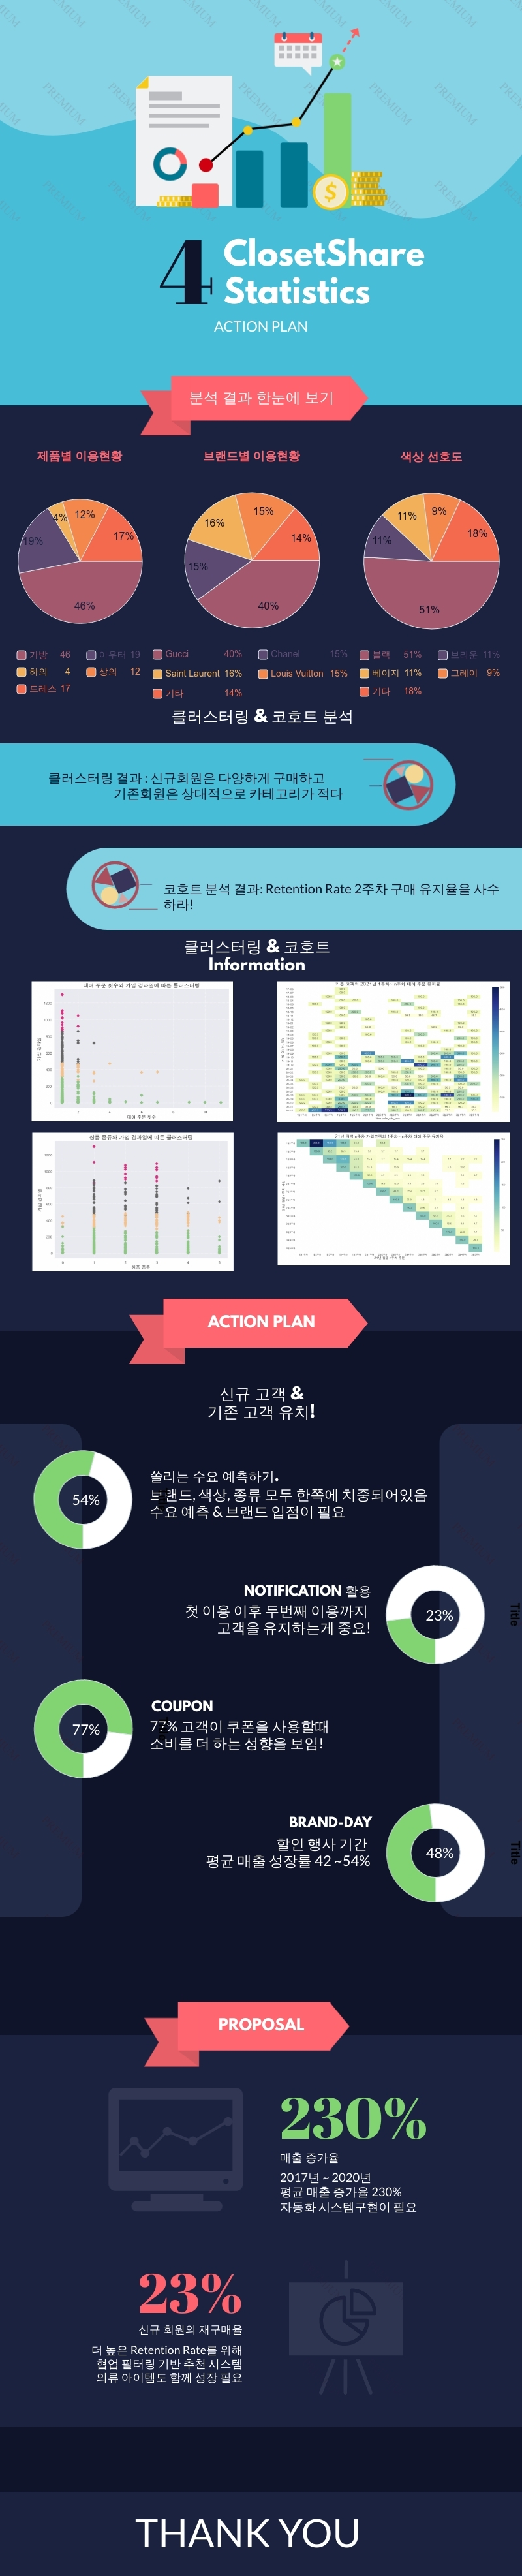